In [1]:
#importing libraries

import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

**Downloading Latest COVID-19 Data From John Hopkins University Directory**

In [2]:
%%time
import requests

for filename in ['time_series_covid19_confirmed_global.csv',
                 'time_series_covid19_deaths_global.csv',
                 'time_series_covid19_recovered_global.csv',
                 ]:
    print(f'Downloading {filename}')
    url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/{filename}'
    myfile = requests.get(url)
    open(filename, 'wb').write(myfile.content)

CPU times: user 64.1 ms, sys: 8.79 ms, total: 72.9 ms
Wall time: 448 ms


**Removing unnessecary columns and converting dates into datetime format**

In [3]:
from datetime import datetime

def _convert_date_str(df):
    try:
        df.columns = list(df.columns[:4]) + [datetime.strptime(d, "%m/%d/%y").date().strftime("%Y-%m-%d") for d in df.columns[4:]]
    except:
        print('_convert_date_str failed with %y, try %Y')
        df.columns = list(df.columns[:4]) + [datetime.strptime(d, "%m/%d/%Y").date().strftime("%Y-%m-%d") for d in df.columns[4:]]


confirmed_global_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
_convert_date_str(confirmed_global_df)

deaths_global_df = pd.read_csv('time_series_covid19_deaths_global.csv')
_convert_date_str(deaths_global_df)

recovered_global_df = pd.read_csv('time_series_covid19_recovered_global.csv')
_convert_date_str(recovered_global_df)

**Filtering out problematic data points**

In [4]:


confirmed_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)
deaths_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)
recovered_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)



In [5]:
confirmed_global_melt_df = confirmed_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='ConfirmedCases')
deaths_global_melt_df = deaths_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='Deaths')
recovered_global_melt_df = deaths_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='Recovered')

**Merging confirmed, deaths and recovered datasets**

In [6]:
train = confirmed_global_melt_df.merge(deaths_global_melt_df, on=['Country_Region', 'Province_State', 'Lat', 'Long', 'Date'])
train = train.merge(recovered_global_melt_df, on=['Country_Region', 'Province_State', 'Lat', 'Long', 'Date'])

**Removing rows with empty values and renaming columns**

In [7]:
train.rename({'Country_Region': 'country', 'Province_State': 'province', 'Id': 'id', 'Date': 'date', 'ConfirmedCases': 'confirmed', 'Deaths': 'fatalities', 'Recovered': 'recovered'}, axis=1, inplace=True)
train['country_province'] = train['country'].fillna('') + '/' + train['province'].fillna('')

**Filtering European Countries**

In [8]:
europe_country_list =list([
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland',
    'Italy', 'Latvia','Luxembourg','Lithuania','Malta','Norway','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
    'Spain', 'Sweden', 'United Kingdom', 'Iceland', 'Russia', 'Switzerland', 'Serbia', 'Ukraine', 'Belarus',
    'Albania', 'Bosnia and Herzegovina', 'Kosovo', 'Moldova', 'Montenegro', 'North Macedonia'])

In [9]:
train = train[train['country'].isin(europe_country_list)]

**Grouping the data by date by summing the particular rows**

In [10]:
train = train.groupby(['date', 'country']).sum()

In [11]:
train = train.drop(['Lat', 'Long'], axis = 1)
train.reset_index(inplace=True)


**Importing latest vaccination data**

In [12]:
vaccination = pd.read_csv('../input/covid-world-vaccination-progress/country_vaccinations.csv')

In [13]:
vaccination = vaccination.drop(['iso_code', 'source_name', 'source_website'], axis = 1)

In [14]:
europe_country_list =list([
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland',
    'Italy', 'Latvia','Luxembourg','Lithuania','Malta','Norway','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
    'Spain', 'Sweden', 'United Kingdom', 'Iceland', 'Russia', 'Switzerland', 'Serbia', 'Ukraine', 'Belarus',
    'Albania', 'Bosnia and Herzegovina', 'Kosovo', 'Moldova', 'Montenegro', 'North Macedonia'])

vaccination = vaccination[vaccination['country'].isin(europe_country_list)]


In [15]:
vcc_all = vaccination.drop(['vaccines'], axis = 1)
vcc_all = vcc_all.groupby(['date']).sum()
vcc_all.reset_index(inplace=True)


In [16]:
train

date                 country  confirmed  fatalities  recovered
0      2020-01-22                 Albania          0           0          0
1      2020-01-22                 Austria          0           0          0
2      2020-01-22                 Belarus          0           0          0
3      2020-01-22                 Belgium          0           0          0
4      2020-01-22  Bosnia and Herzegovina          0           0          0
...           ...                     ...        ...         ...        ...
19019  2021-04-29                   Spain    3514942       78080      78080
19020  2021-04-29                  Sweden     967678       14002      14002
19021  2021-04-29             Switzerland     658143       10625      10625
19022  2021-04-29                 Ukraine    2113880       45607      45607
19023  2021-04-29          United Kingdom    4429849      127759     127759

[19024 rows x 5 columns]

In [17]:
vaccination

country        date  total_vaccinations  people_vaccinated  \
60            Albania  2021-01-10                 0.0                0.0   
61            Albania  2021-01-11                 NaN                NaN   
62            Albania  2021-01-12               128.0              128.0   
63            Albania  2021-01-13               188.0              188.0   
64            Albania  2021-01-14               266.0              266.0   
...               ...         ...                 ...                ...   
13708  United Kingdom  2021-04-22          45012308.0         33388637.0   
13709  United Kingdom  2021-04-23          45613109.0         33524423.0   
13710  United Kingdom  2021-04-24          46309512.0         33673190.0   
13711  United Kingdom  2021-04-25          46650008.0         33752885.0   
13712  United Kingdom  2021-04-26          47045391.0         33843580.0   

       people_fully_vaccinated  daily_vaccinations_raw  daily_vaccinations  \
60                         NaN                     NaN                 NaN   
61                         NaN                     NaN                64.0   
62                         NaN                     NaN                64.0   
63                         NaN                    60.0                63.0   
64                         NaN                    78.0                66.0   
...                        ...                     ...                 ...   
13708               11623671.0                562056.0            500934.0   
13709               12088686.0                600801.0            496017.0   
13710               12636322.0                696403.0            504206.0   
13711               12897123.0                340496.0            509360.0   
13712               13201811.0                395383.0            512497.0   

       total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
60                               0.00                           0.00   
61                                NaN                            NaN   
62                               0.00                           0.00   
63                               0.01                           0.01   
64                               0.01                           0.01   
...                               ...                            ...   
13708                           66.31                          49.18   
13709                           67.19                          49.38   
13710                           68.22                          49.60   
13711                           68.72                          49.72   
13712                           69.30                          49.85   

       people_fully_vaccinated_per_hundred  daily_vaccinations_per_million  \
60                                     NaN                             NaN   
61                                     NaN                            22.0   
62                                     NaN                            22.0   
63                                     NaN                            22.0   
64                                     NaN                            23.0   
...                                    ...                             ...   
13708                                17.12                          7379.0   
13709                                17.81                          7307.0   
13710                                18.61                          7427.0   
13711                                19.00                          7503.0   
13712                                19.45                          7549.0   

                                           vaccines  
60                         Pfizer/BioNTech, Sinovac  
61                         Pfizer/BioNTech, Sinovac  
62                         Pfizer/BioNTech, Sinovac  
63                         Pfizer/BioNTech, Sinovac  
64                         Pfizer/BioNTech, Sinovac  
...                                   

In [18]:
vcc_all

date  total_vaccinations  people_vaccinated  \
0    2020-12-15             28500.0            28500.0   
1    2020-12-16                 0.0                0.0   
2    2020-12-17                 0.0                0.0   
3    2020-12-18                 0.0                0.0   
4    2020-12-19                 0.0                0.0   
..          ...                 ...                ...   
129  2021-04-23         199874843.0        139938501.0   
130  2021-04-24         167680182.0        115410692.0   
131  2021-04-25         195368330.0        136687072.0   
132  2021-04-26         188279618.0        130516097.0   
133  2021-04-27          78057007.0         55034524.0   

     people_fully_vaccinated  daily_vaccinations_raw  daily_vaccinations  \
0                        0.0                     0.0                 0.0   
1                        0.0                     0.0              3357.0   
2                        0.0                     0.0              3357.0   
3                        0.0                     0.0              3357.0   
4                        0.0                     0.0              3357.0   
..                       ...                     ...                 ...   
129               54509475.0               3953761.0           3371314.0   
130               46747070.0               2880543.0           3419129.0   
131               53516251.0               1444116.0           3370665.0   
132               52600007.0               2485415.0           3340644.0   
133               23132270.0               1045864.0           1387310.0   

     total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
0                              0.02                           0.02   
1                              0.00                           0.00   
2                              0.00                           0.00   
3                              0.00                           0.00   
4                              0.00                           0.00   
..                              ...                            ...   
129                          974.95                         671.53   
130                          785.65                         526.61   
131                          876.62                         613.29   
132                          851.38                         586.18   
133                          488.47                         358.45   

     people_fully_vaccinated_per_hundred  daily_vaccinations_per_million  
0                                   0.00                             0.0  
1                                   0.00                            23.0  
2                                   0.00                            23.0  
3                                   0.00                            23.0  
4                                   0.00                            23.0  
..                                   ...                             ...  
129                               260.44                        175850.0  
130                               215.22                        168115.0  
131                               233.06                        164221.0  
132                               236.36                        152943.0  
133                               130.26                         85429.0  

[134 rows x 10 columns]

In [19]:
train_all = train.groupby(['date']).sum()
train_all.reset_index(inplace=True)
train_all

date  confirmed  fatalities  recovered
0    2020-01-22          0           0          0
1    2020-01-23          0           0          0
2    2020-01-24          2           0          0
3    2020-01-25          3           0          0
4    2020-01-26          3           0          0
..          ...        ...         ...        ...
459  2021-04-25   44149523     1000388    1000388
460  2021-04-26   44240396     1003203    1003203
461  2021-04-27   44390209     1006720    1006720
462  2021-04-28   44551973     1010227    1010227
463  2021-04-29   44707890     1013509    1013509

[464 rows x 4 columns]

**Getting separated dates so that visualisation is clean**

In [20]:
def get_date_ticks(df,ngaps=7):
    dates    = df.date.unique()
    n        = len(dates)-1
    stepsize = int(n/ngaps)
    return [dates[i] for i in range(0,n+1,stepsize)]



def get_date_range(df):
    return '{0} - {1}'.format(get_date_str(df.date.min()),get_date_str(df.date.max()))

In [21]:
def get_date_str(d0,fmt='%d %b %Y'):
   return pd.to_datetime(d0).strftime(fmt)

**Function that returns the date when the vaccination in a given country started**

In [22]:
def get_vaccination_started_date(country):
   first = vaccination.loc[vaccination.total_vaccinations > 0, ["country","date"]].groupby(['country']).min()
   return first.loc[country,['date']].values[0]


# **QUALITATIVE ANALYSIS OF EFFECT OF VACCINATION ON COVID-19**

**Forming a title for particular graphs**

The title is in the format of -- Confirmed cases from "Country_name" between "Date_Range", Vaccination started - "Vaccination_starting_date"

In [23]:
def get_title( country, date_range, scaling = 'Confirmed' ):
    status = "Vaccination Started"
    date = get_vaccination_started_date(country)
    return '{0} Cases from {1}: {2}. {3} {4}.'.format(scaling,
                                                        country,
                                                        date_range,
                                                        status,
                                                        get_date_str(date))
 

**Function which returns the plot for the country name that is given as parameter**

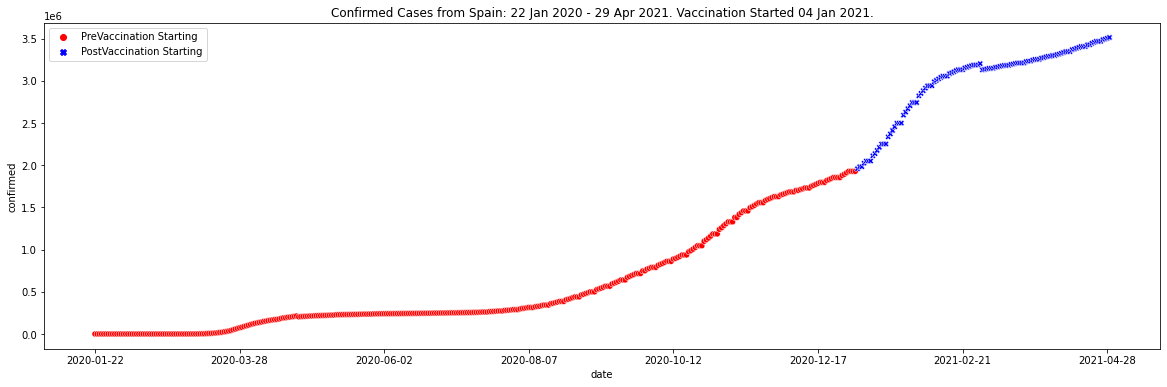

In [24]:
def plot_country(country = 'Spain'):
    vaccination_started_date = get_vaccination_started_date(country)
    country_data        = train.loc[(train.country == country),:]


    dates       = country_data.date
    cases       = country_data.confirmed
 
    vaccination_started = ["PostVaccination Starting" if l else "PreVaccination Starting" for l in pd.to_datetime(country_data.date) >= vaccination_started_date]
 
    plt.figure(figsize=(20,6))
    sns.set_palette("RdBu_r",1)
    
    
    if vaccination_started[0] != vaccination_started[-1]:
        sns.scatterplot(x=dates,y=cases, hue=vaccination_started, style=vaccination_started, palette=['r','b'])
    else: 
        sns.scatterplot(x=dates,y=cases, hue=vaccination_started, style=vaccination_started, palette=['b'])
        
    plt.title(get_title(country, get_date_range(country_data)))
    plt.xticks(get_date_ticks(country_data))
    
    

plot_country()

In [25]:
europian =list([
    'Austria','Belgium', 'Croatia', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
    'Italy','Norway','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
    'Spain', 'Sweden', 'United Kingdom', 'Russia', 'Switzerland', 'Serbia'])

**Plot of every Major European Country**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



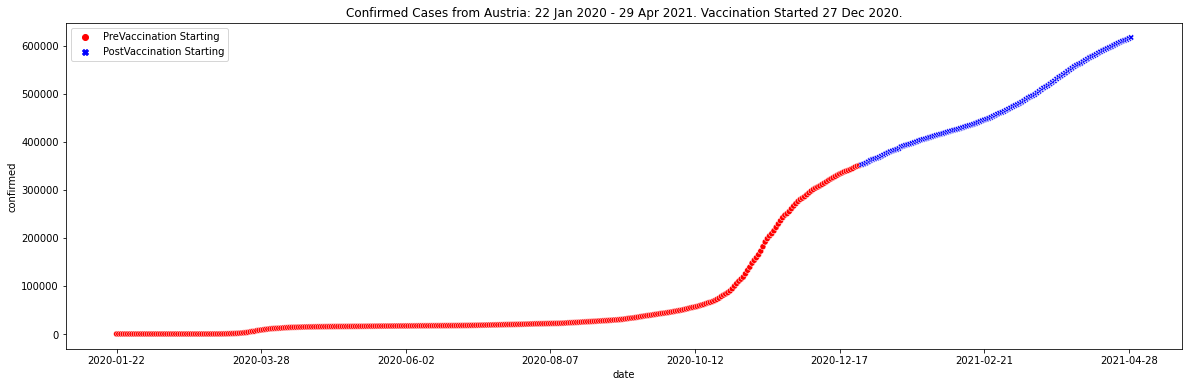

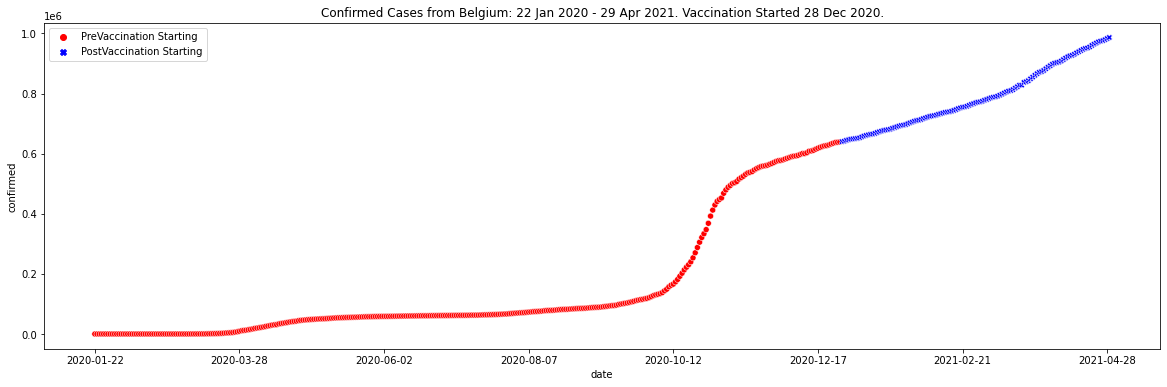

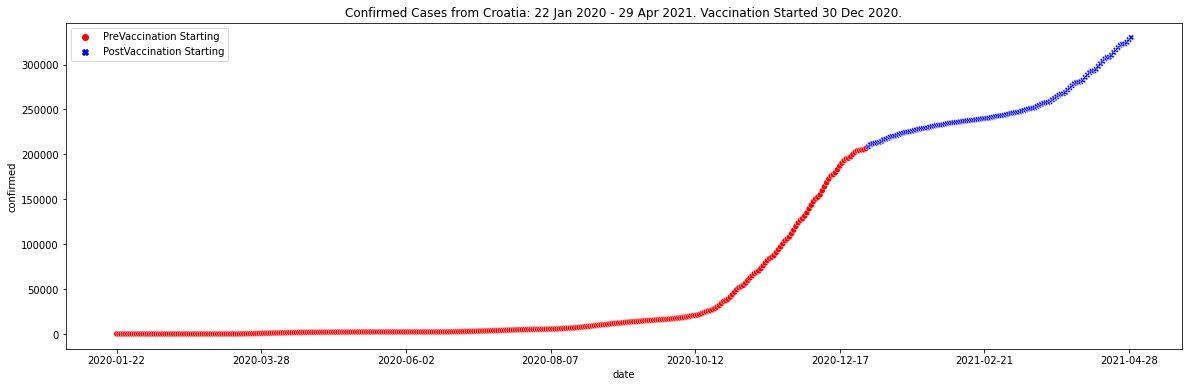

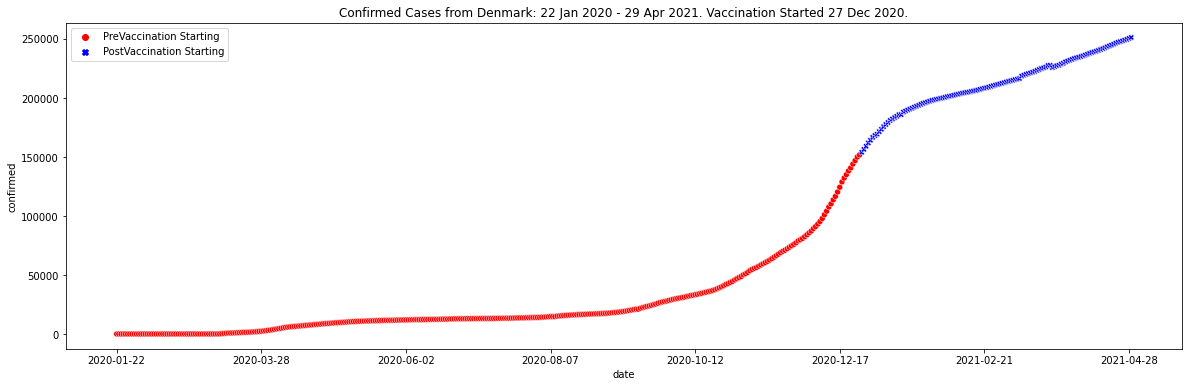

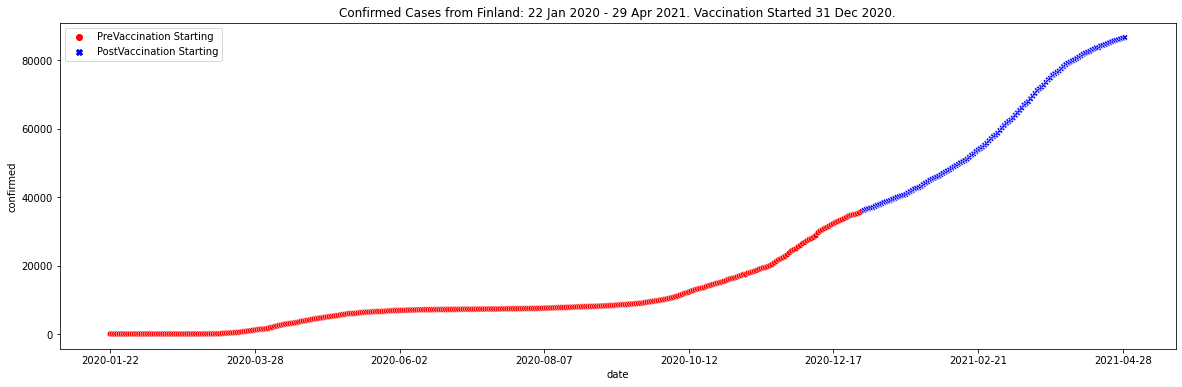

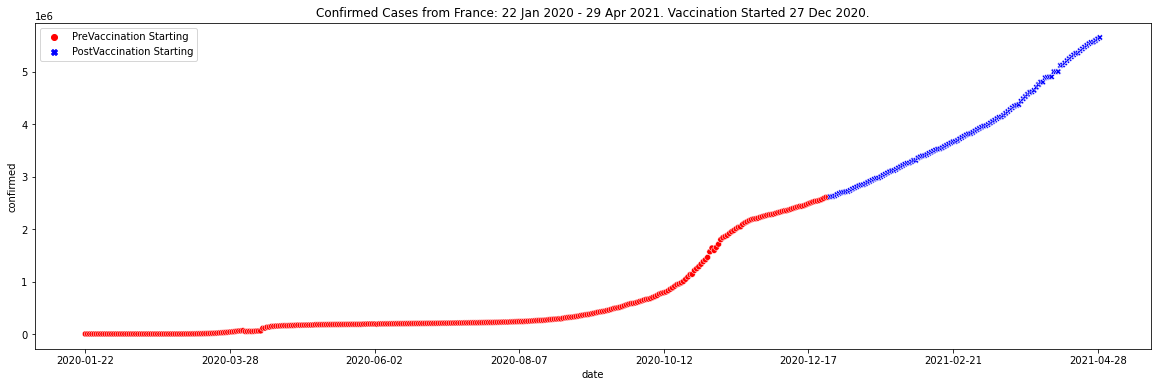

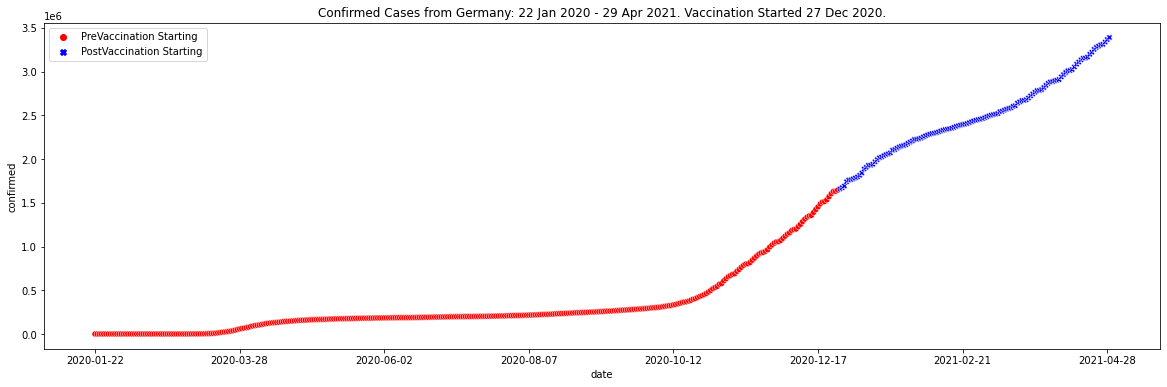

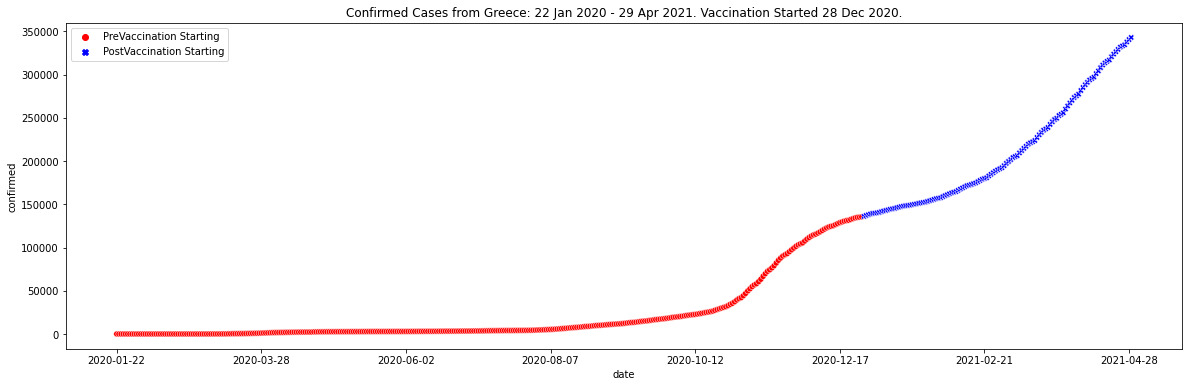

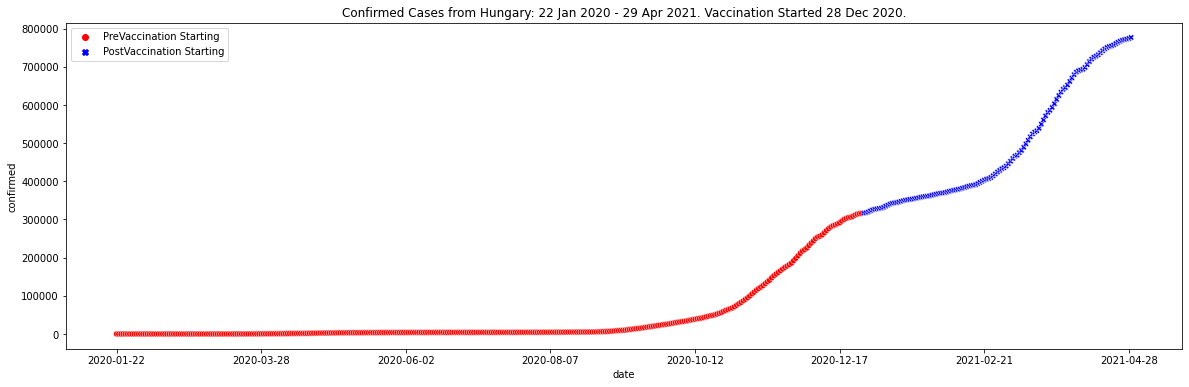

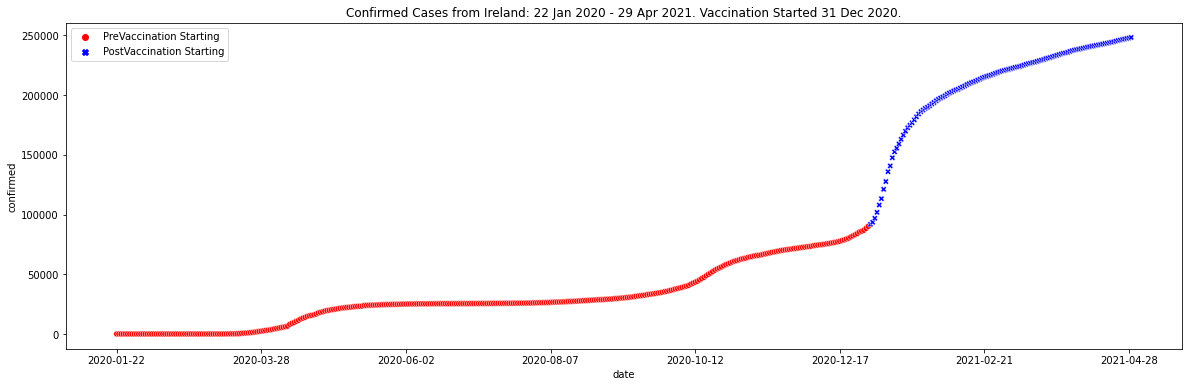

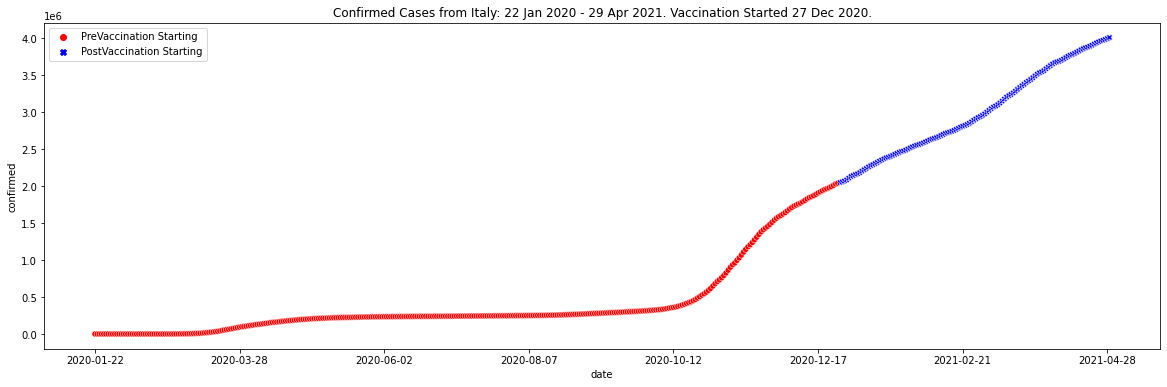

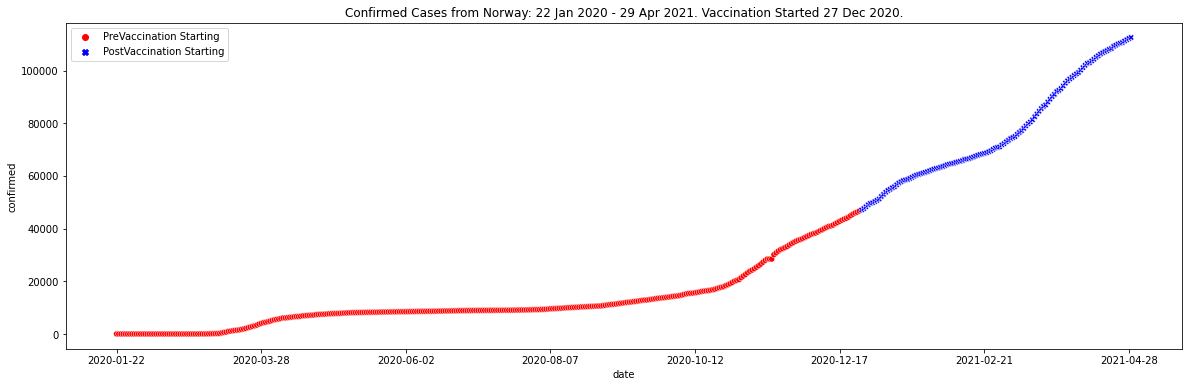

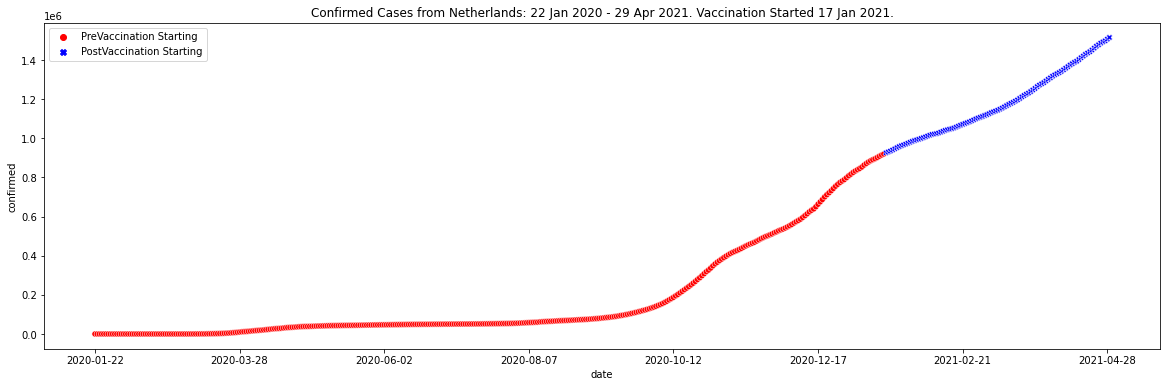

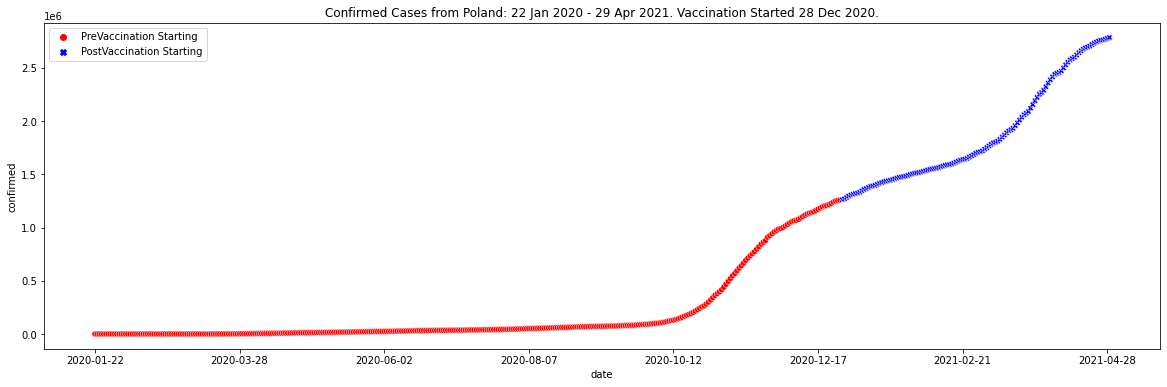

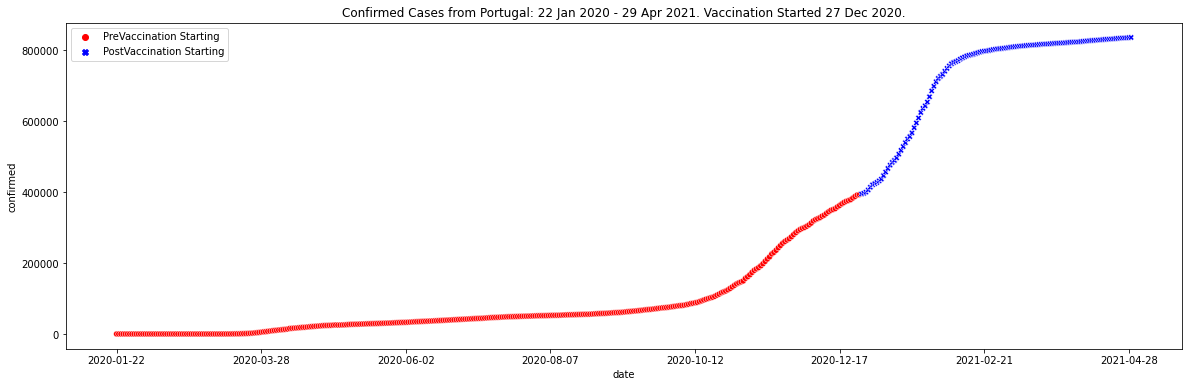

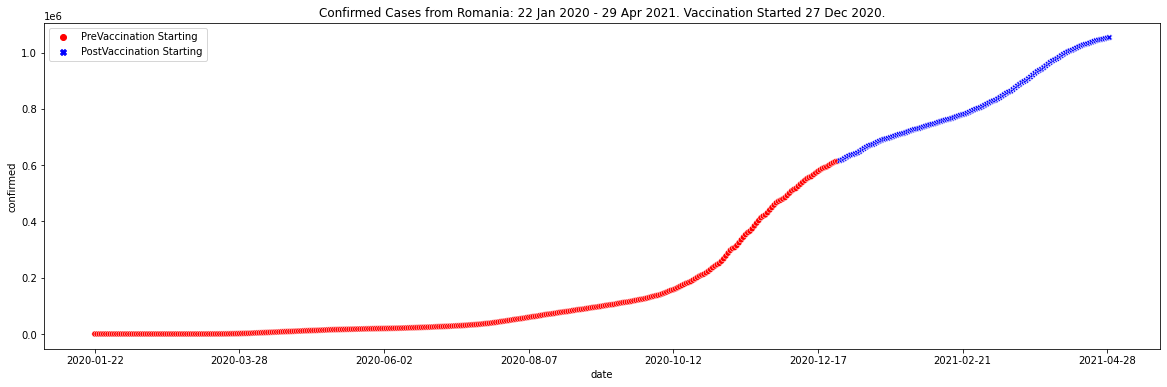

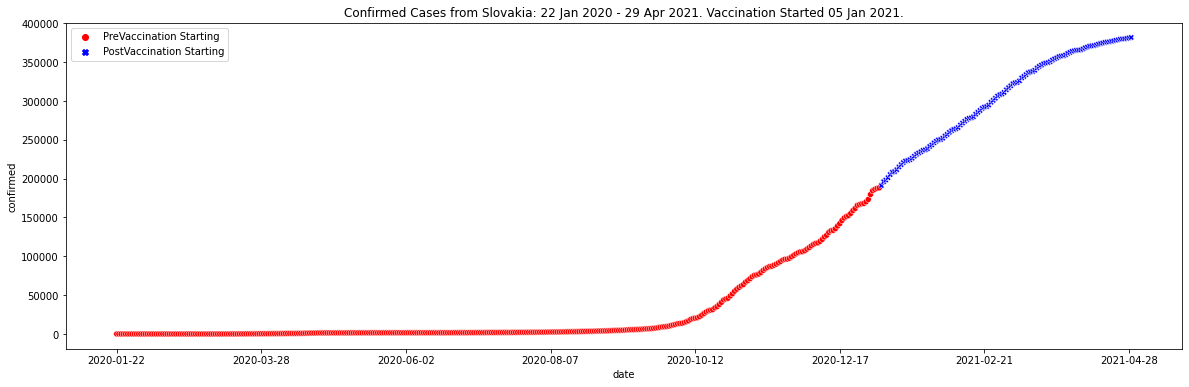

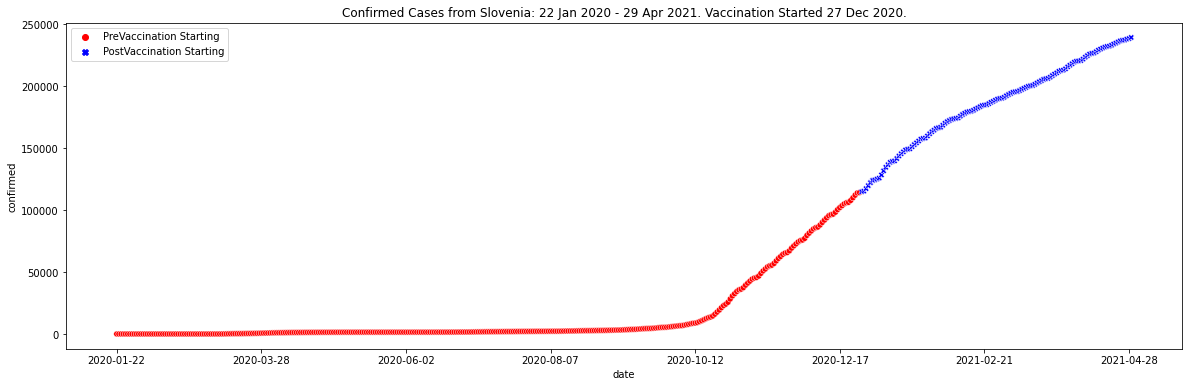

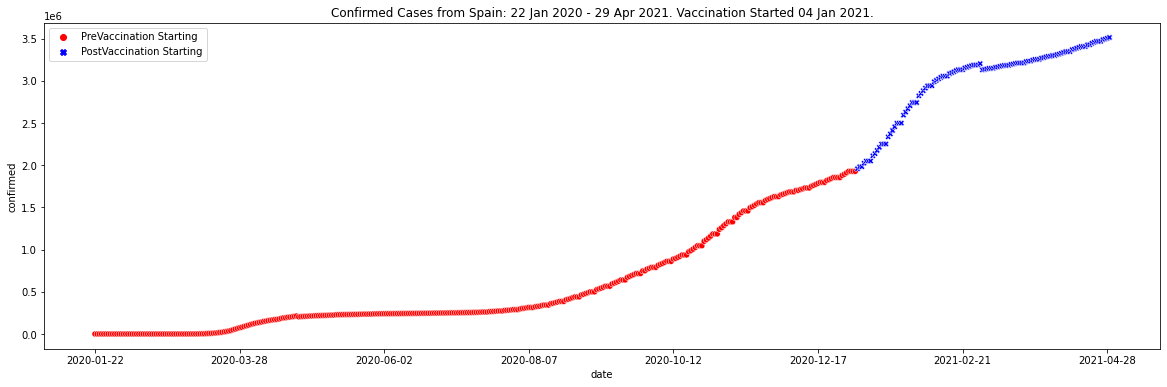

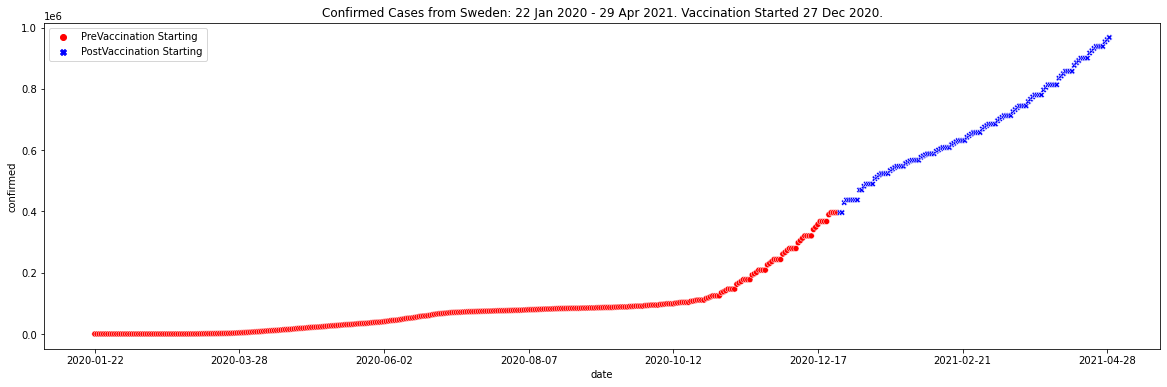

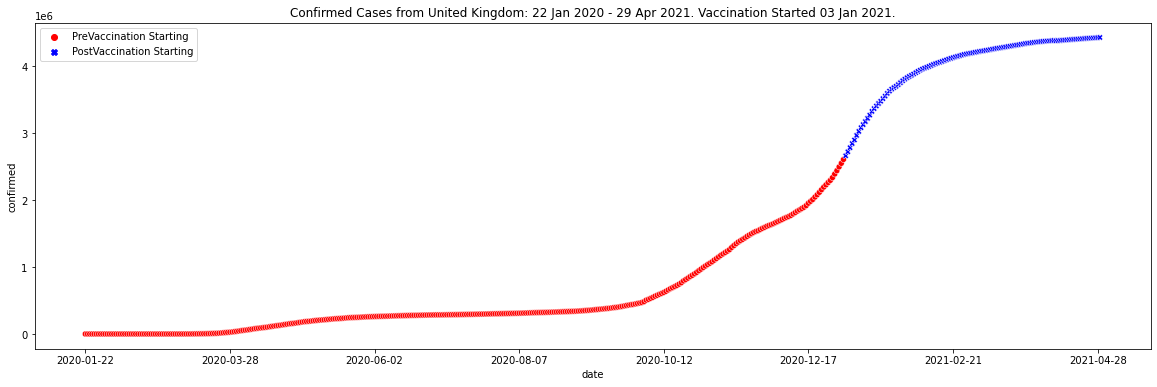

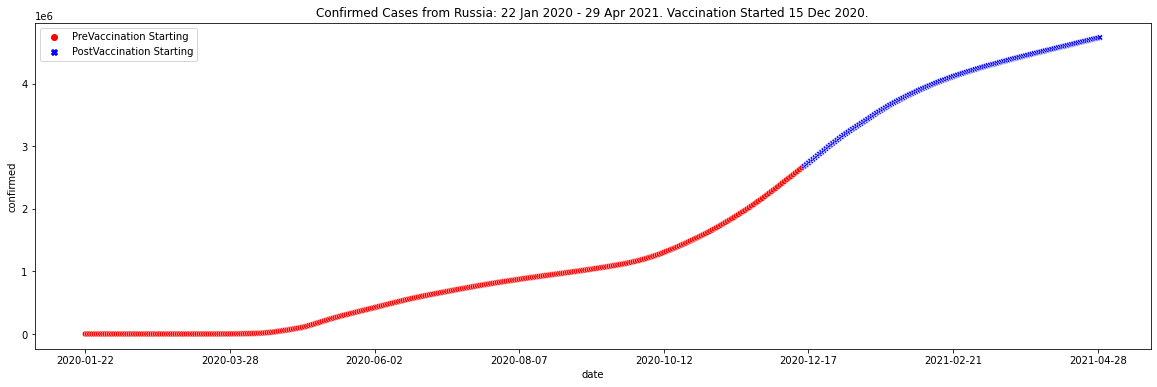

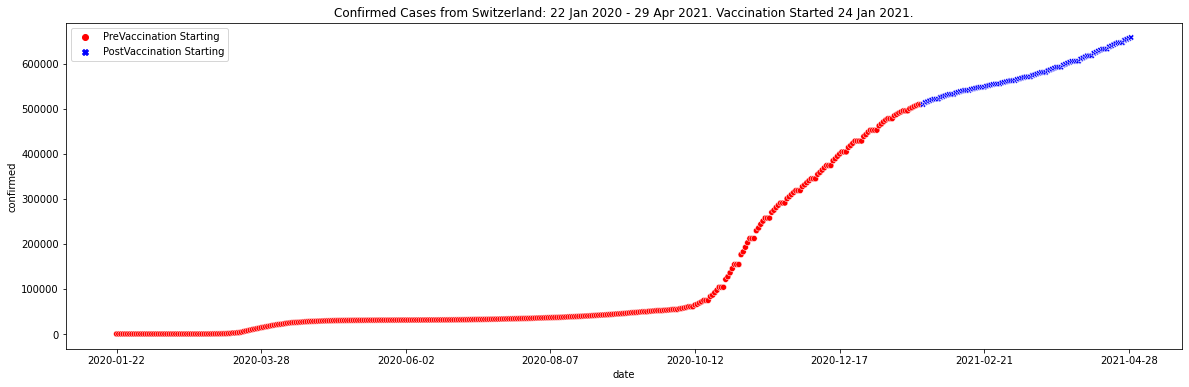

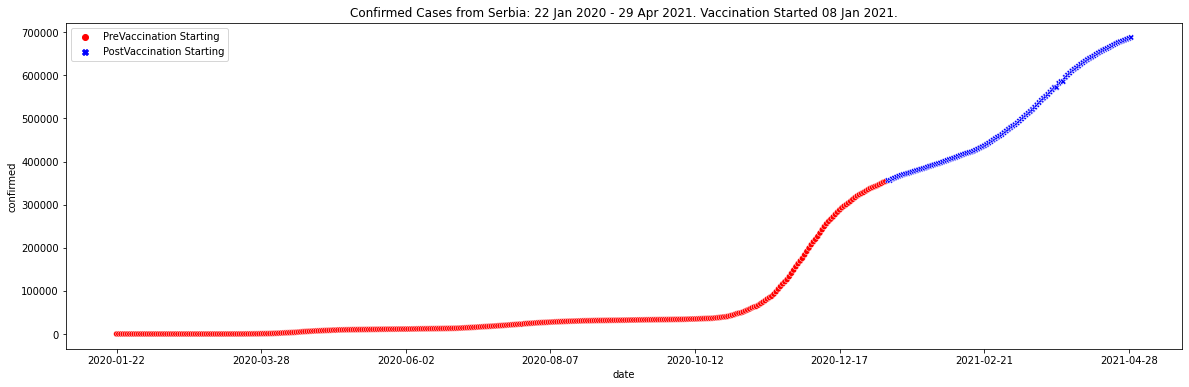

In [26]:
for i in europian:
    plot_country(i)

From the above graphs we can observe that the no of cases does not goes down immediately but after a given the time the curve starts to flatten a bit. Thus the start of vaccination process immediately did not have any major impact on no of cases per day but with time as mosre people got vaccinated , fewer no of confirmed cases were observed. To look further upon this hypothesis let's observe relation between no of cases before and after completion of vaccination of 10% of total population.


**Given Function returns the date at which vaccination of atleast 10% of total population was completed for a givrn Country**

In [27]:
def get_vaccination_tendone(country):
   first = vaccination.loc[vaccination.total_vaccinations_per_hundred > 10, ["country","date"]].groupby(['country']).min()
   return first.loc[country,['date']].values[0]



**Given function returns title of a graph is the specified format**

The format is -- Confirmed Cases from "Country_Name" from "Date_Range". Vaccination 10% done on "Vcc10%done_Date".

In [28]:
def get_title( country, date_range, scaling = 'Confirmed' ):
    status = "Vaccination 10% done"
    date = get_vaccination_tendone(country)
    return '{0} Cases from {1}: {2}. {3} {4}.'.format(scaling,
                                                        country,
                                                        date_range,
                                                        status,
                                                        get_date_str(date))

**Function that return the plot of the country given as a parameter**

In [29]:
def plot_country_ten(country = 'Spain'):
    vaccination_started_date = get_vaccination_tendone(country)
    country_data        = train.loc[(train.country == country),:]


    dates       = country_data.date
    cases       = country_data.confirmed
 
    vaccination_started = ["Post 10%" if l else "Pre 10%" for l in pd.to_datetime(country_data.date) >= vaccination_started_date]
 
    plt.figure(figsize=(20,6))
    sns.set_palette("RdBu_r",1)
    
    
    if vaccination_started[0] != vaccination_started[-1]:
        sns.scatterplot(x=dates,y=cases, hue=vaccination_started, style=vaccination_started, palette=['r','b'])
    else: 
        sns.scatterplot(x=dates,y=cases, hue=vaccination_started, style=vaccination_started, palette=['b'])
        
    plt.title(get_title(country, get_date_range(country_data)))
    plt.xticks(get_date_ticks(country_data))
    


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



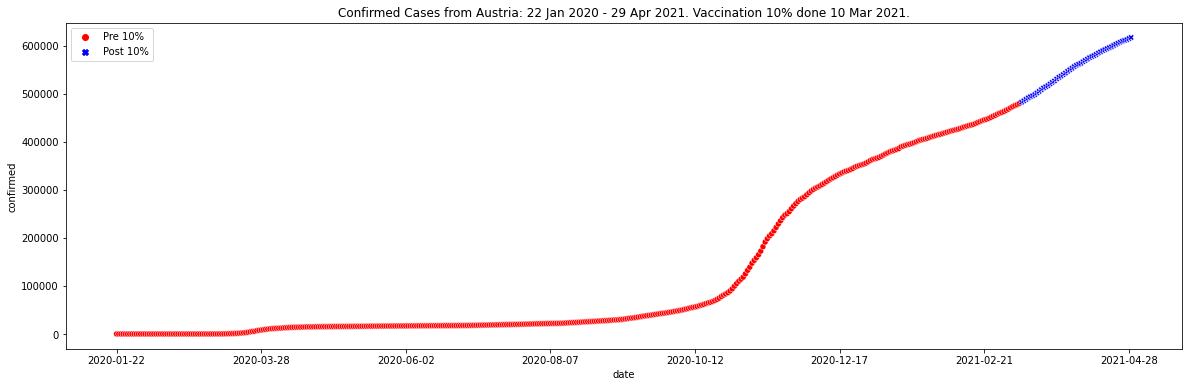

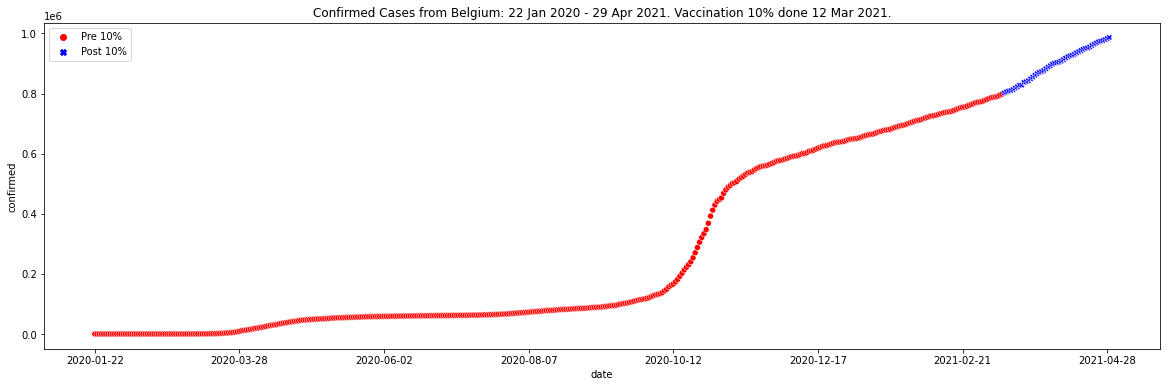

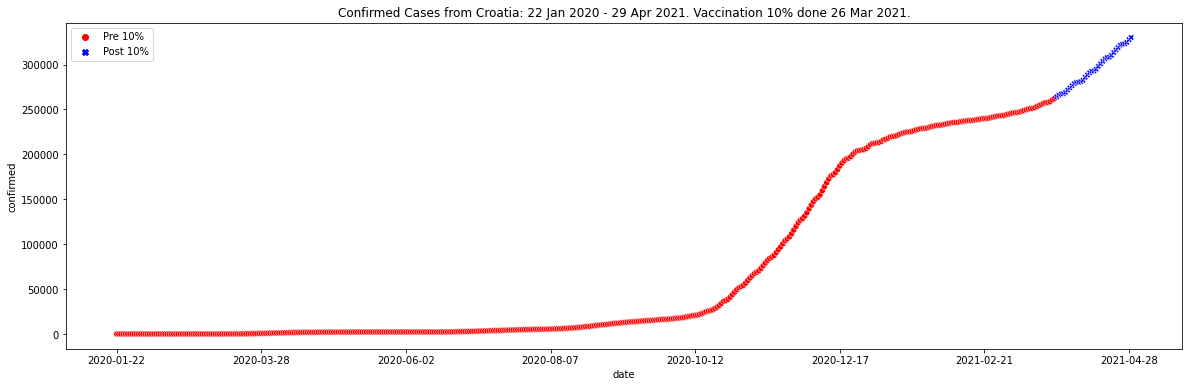

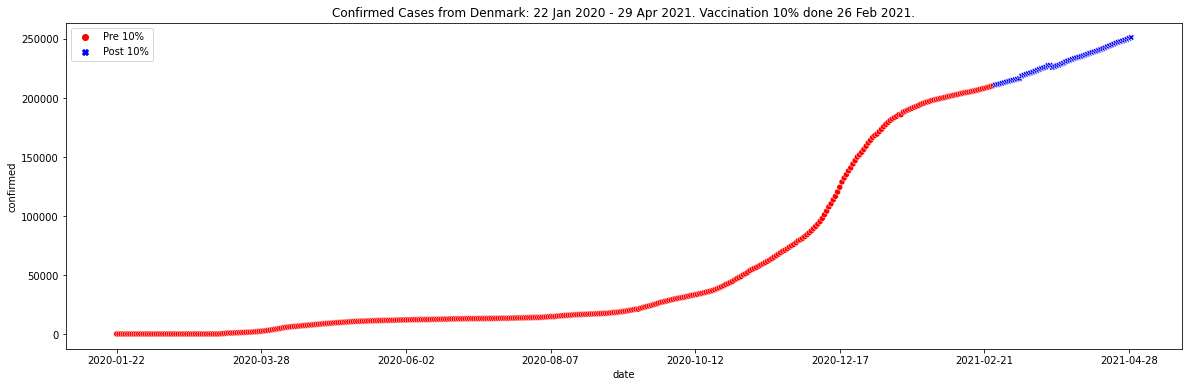

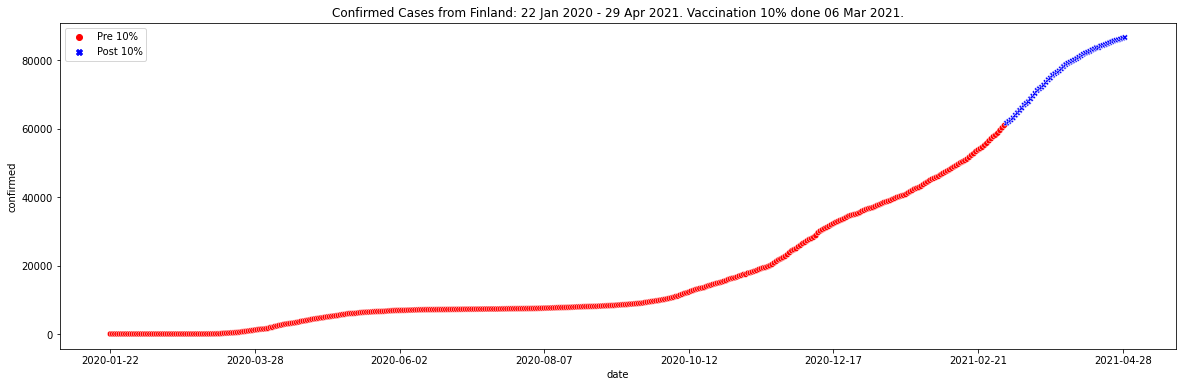

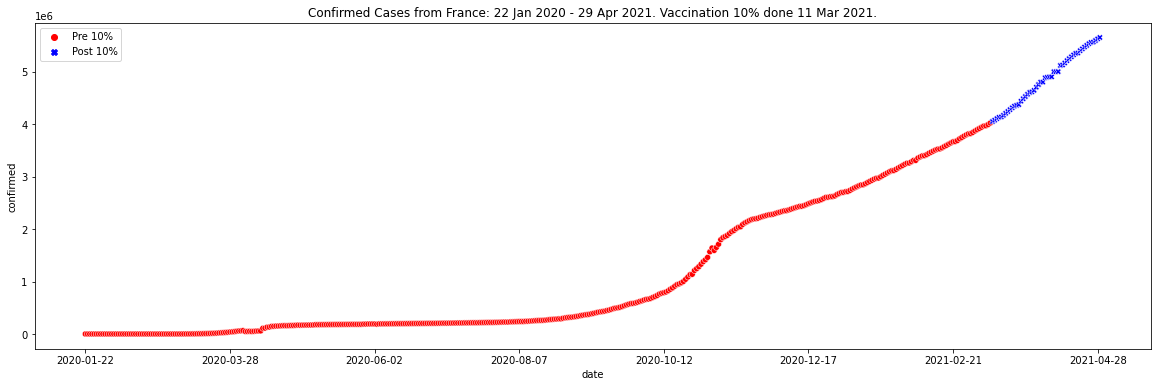

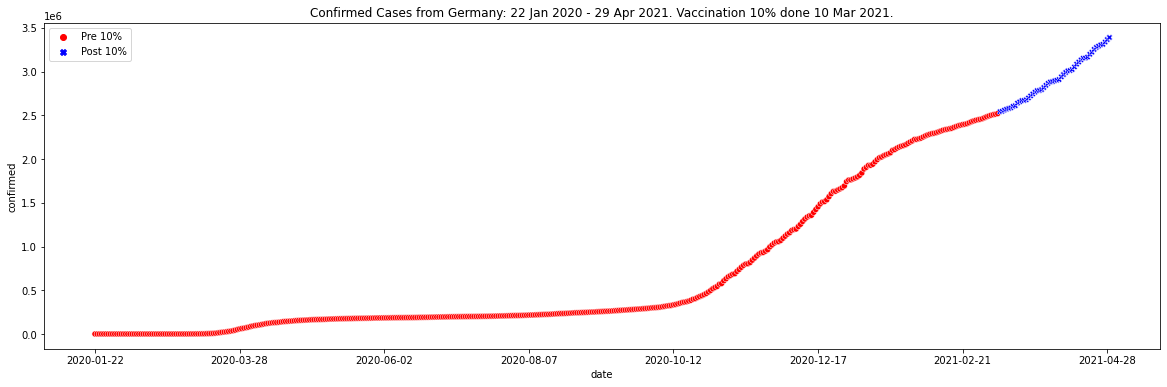

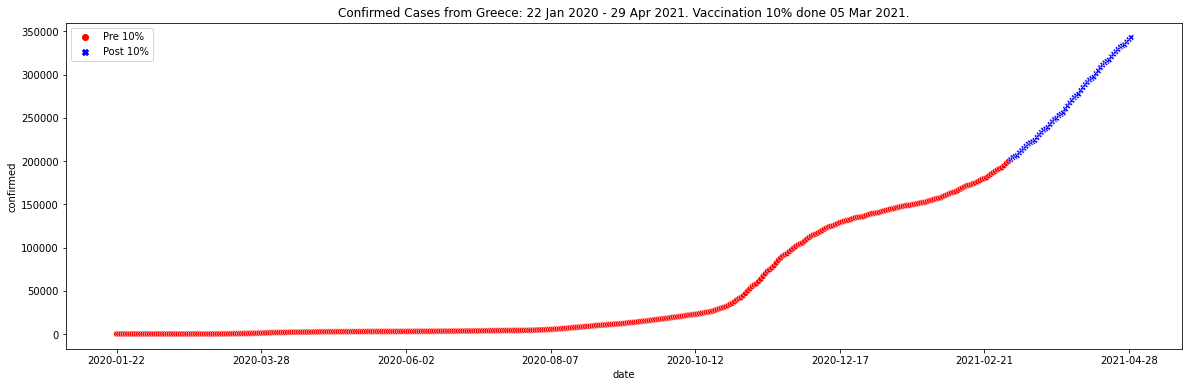

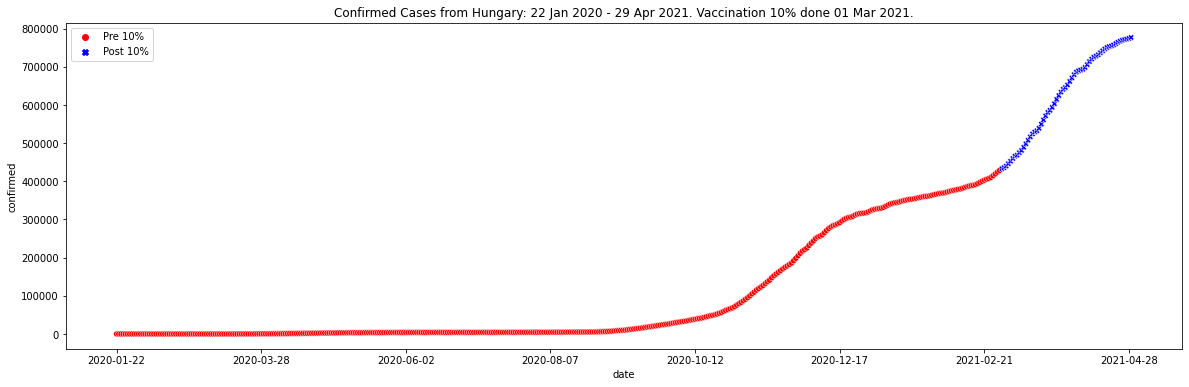

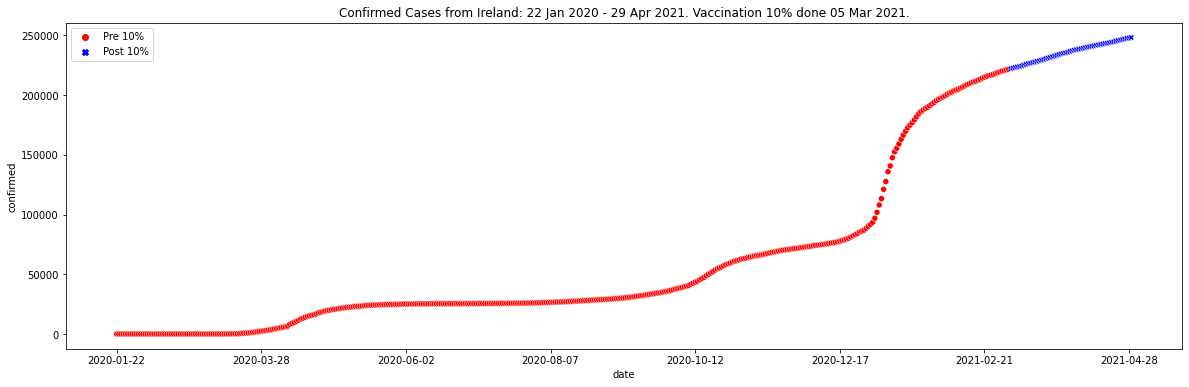

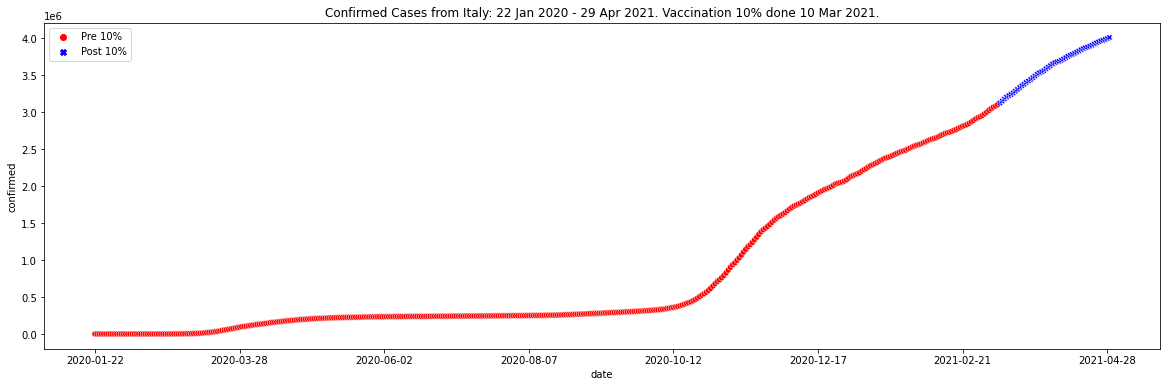

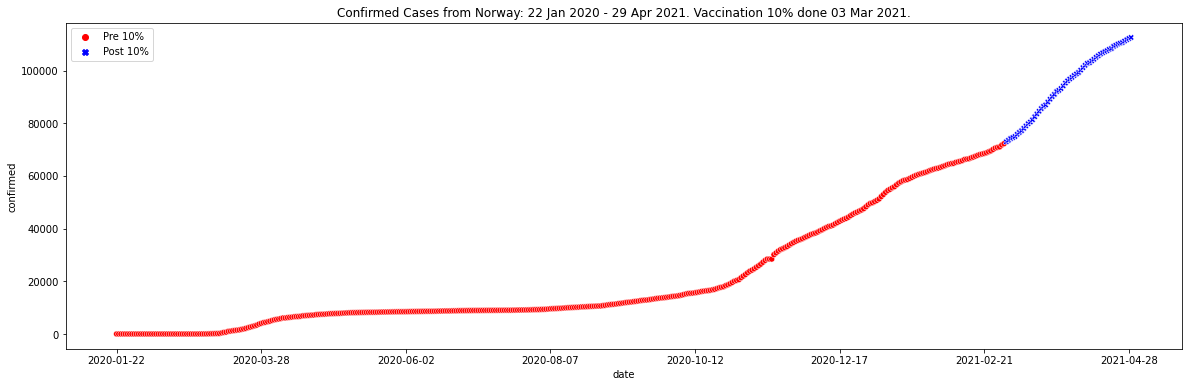

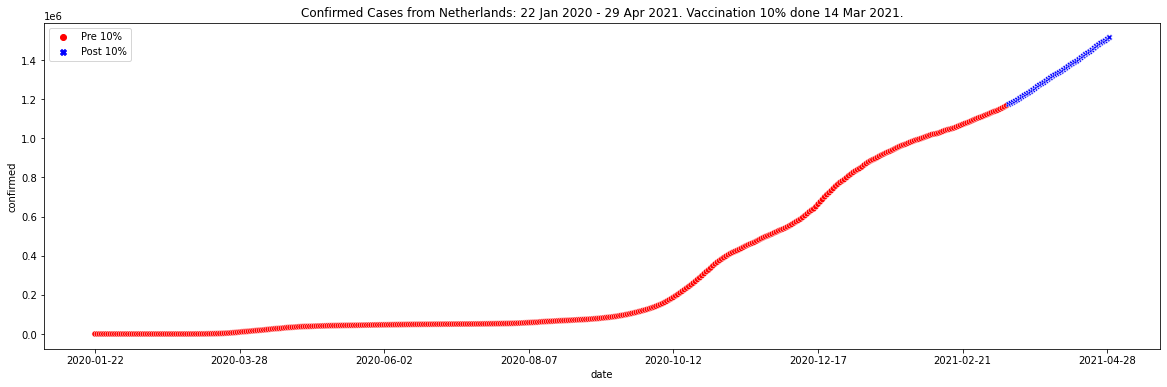

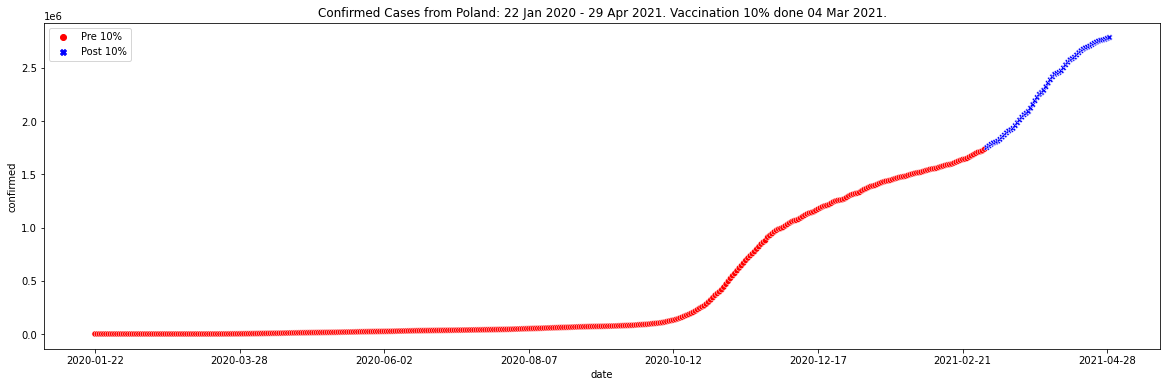

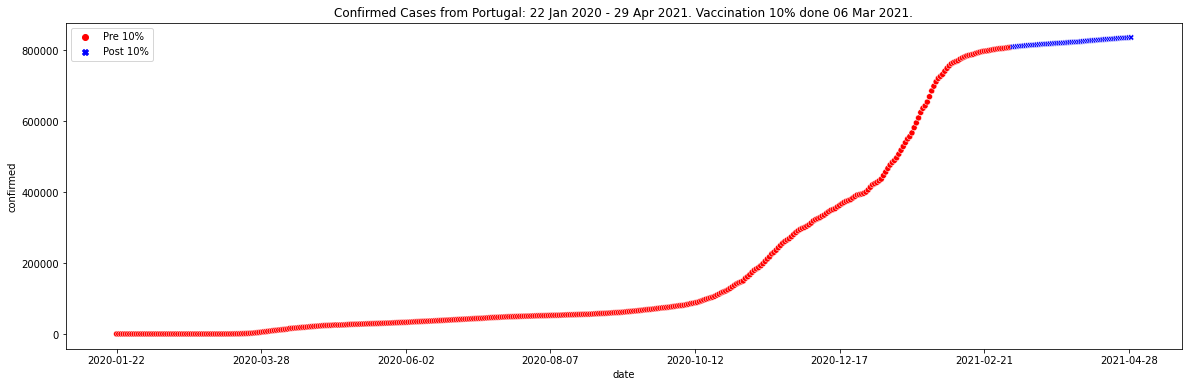

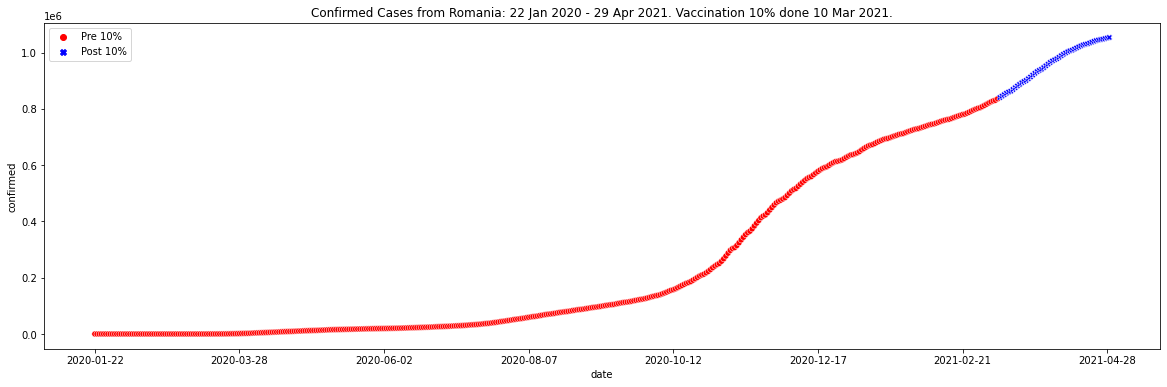

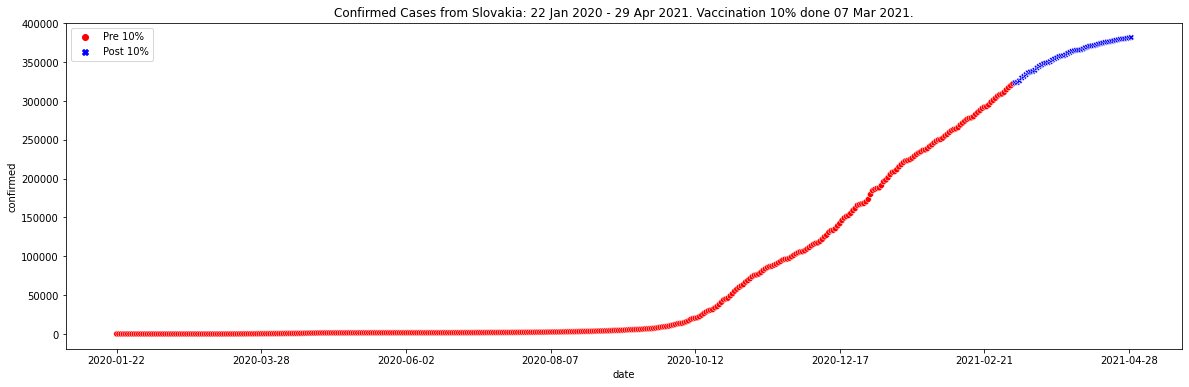

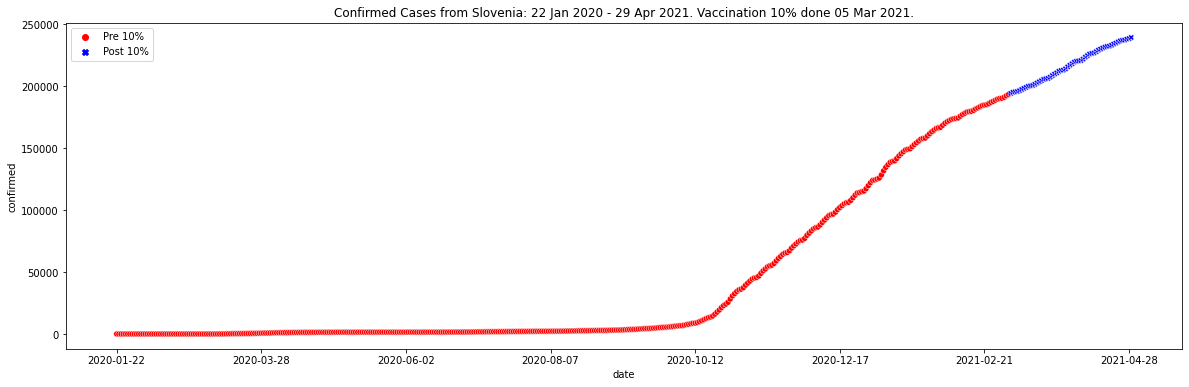

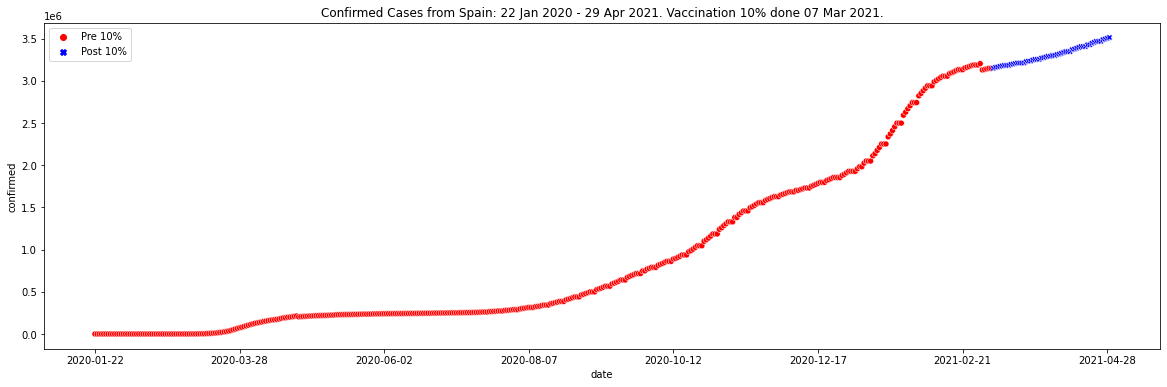

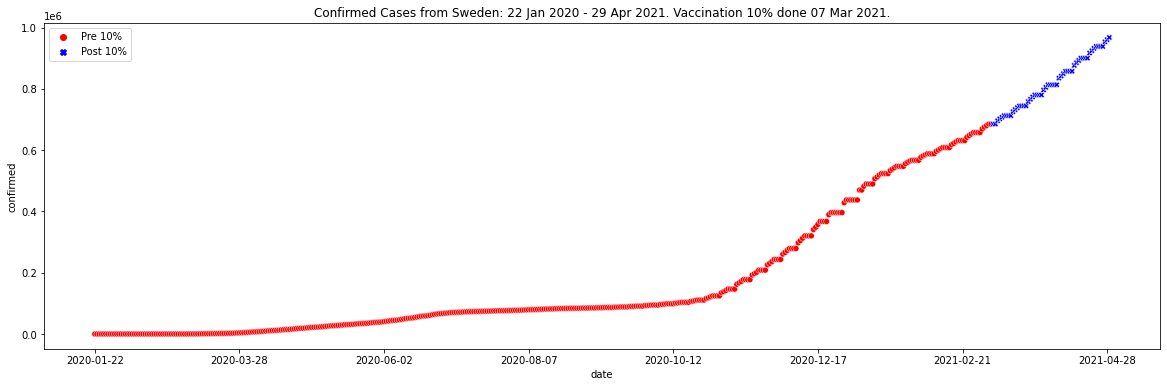

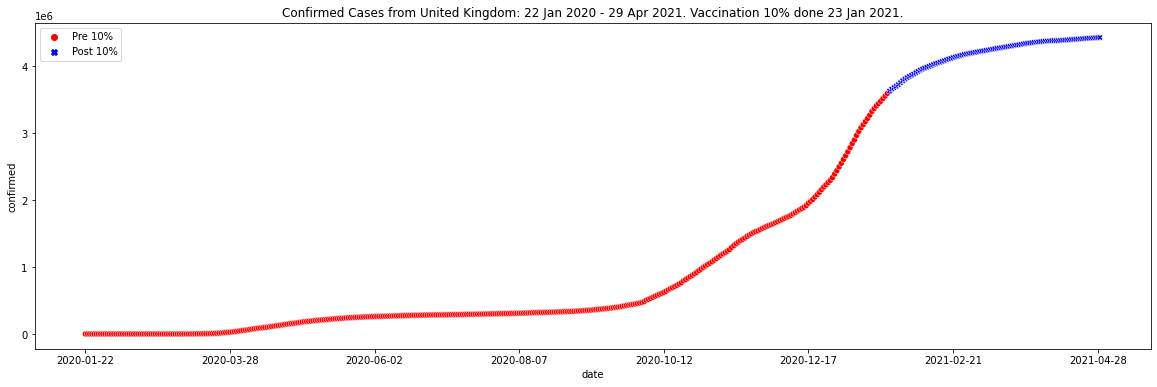

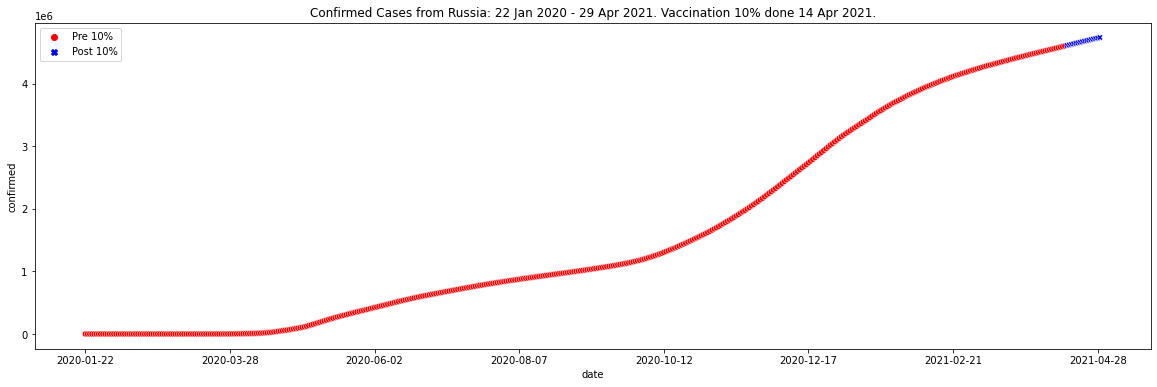

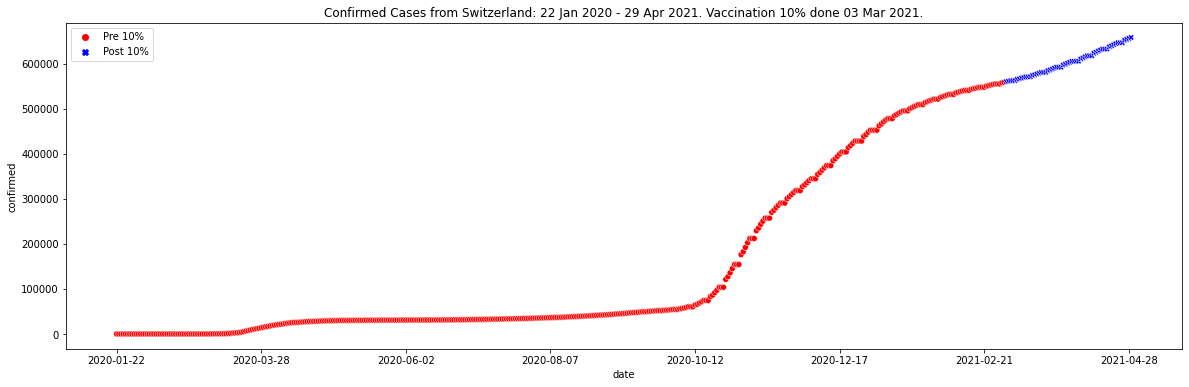

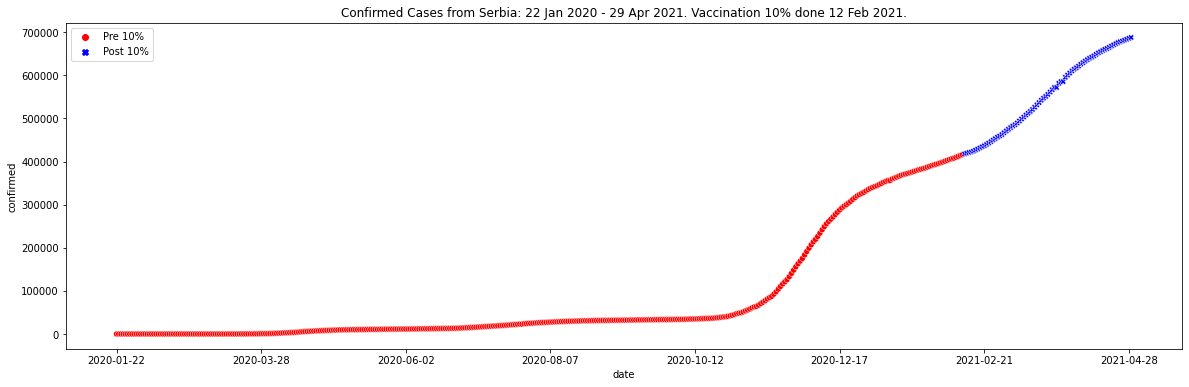

In [30]:
for i in europian:
    plot_country_ten(i)

From the above graphs we can obsereve that the no of cases starts dwindling gradually as more and more people are vaccinated and more or less every country has been able to flatten the curve. However due to increased mobility after start of the vaccination process few countries has also not been able to curb the groth of no of cases. Now we look upon the relation between vaccination and no of deaths recorded.

In [31]:
def get_title( country, date_range, scaling = 'Fatalities' ):
    status = "Vaccination Started"
    date = get_vaccination_started_date(country)
    return '{0} Cases from {1}: {2}. {3} {4}.'.format(scaling,
                                                        country,
                                                        date_range,
                                                        status,
                                                        get_date_str(date))

In [32]:
def plot_country_fatalities(country = 'Spain'):
    vaccination_started_date = get_vaccination_started_date(country)
    country_data        = train.loc[(train.country == country),:]


    dates       = country_data.date
    cases       = country_data.fatalities
 
    vaccination_started = ["PostVaccination Starting" if l else "PreVaccination Starting" for l in pd.to_datetime(country_data.date) >= vaccination_started_date]
 
    plt.figure(figsize=(20,6))
    sns.set_palette("RdBu_r",1)
    
    
    if vaccination_started[0] != vaccination_started[-1]:
        sns.scatterplot(x=dates,y=cases, hue=vaccination_started, style=vaccination_started, palette=['r','b'])
    else: 
        sns.scatterplot(x=dates,y=cases, hue=vaccination_started, style=vaccination_started, palette=['b'])
        
    plt.title(get_title(country, get_date_range(country_data)))
    plt.xticks(get_date_ticks(country_data))
    
    


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



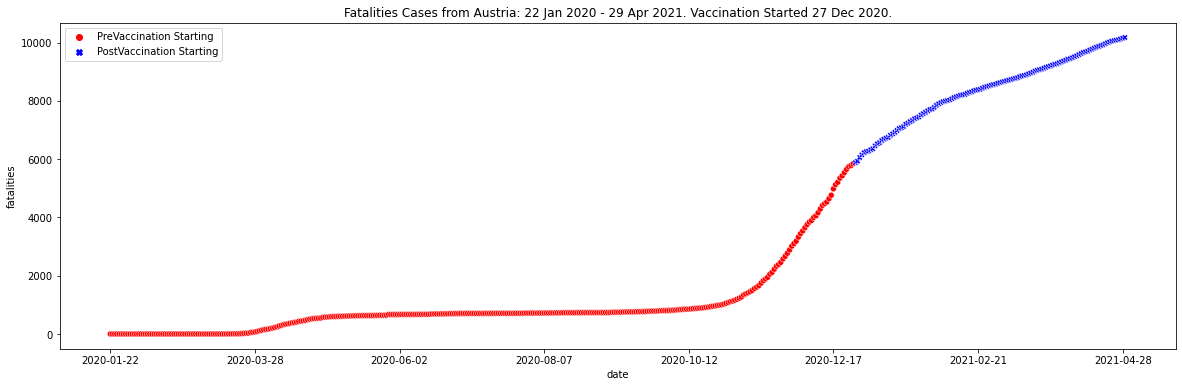

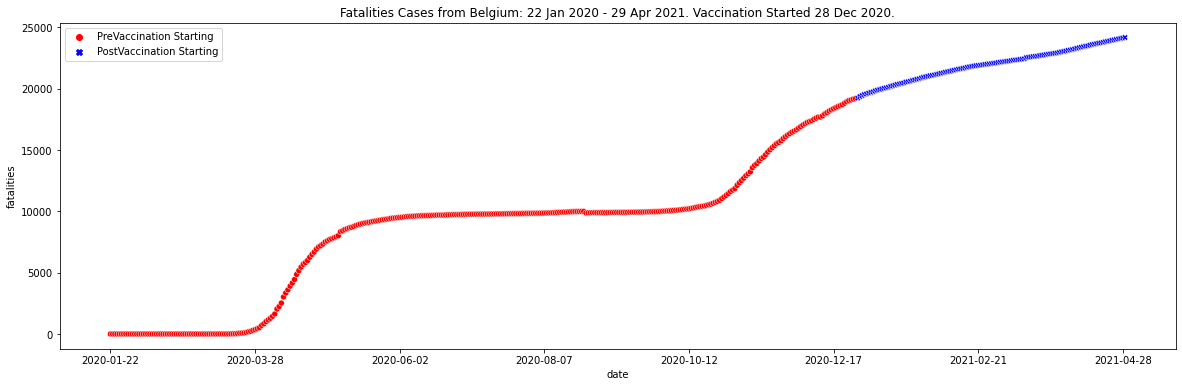

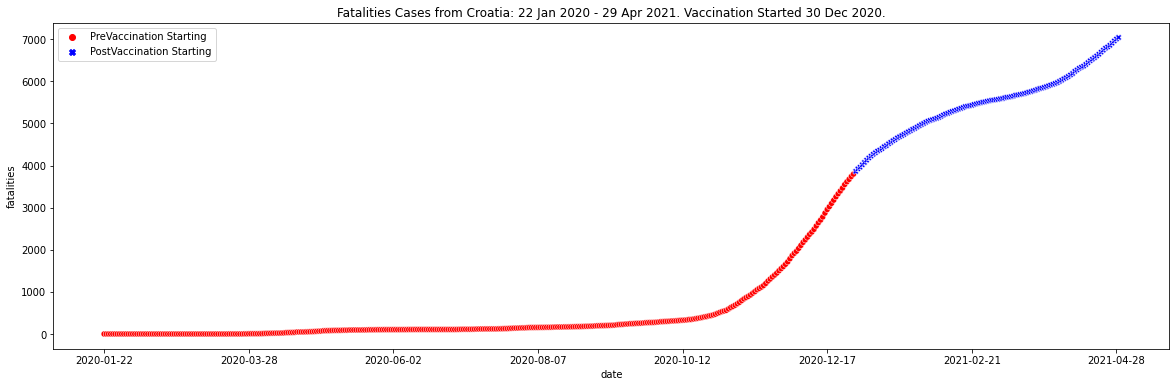

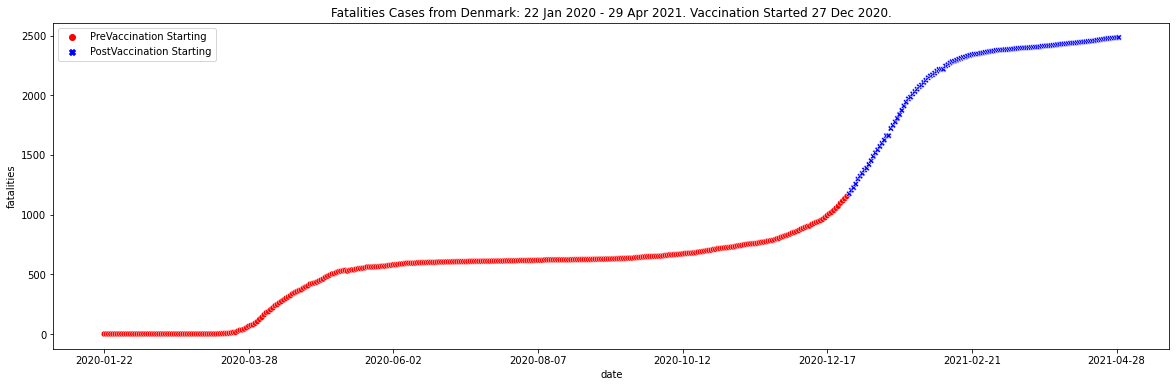

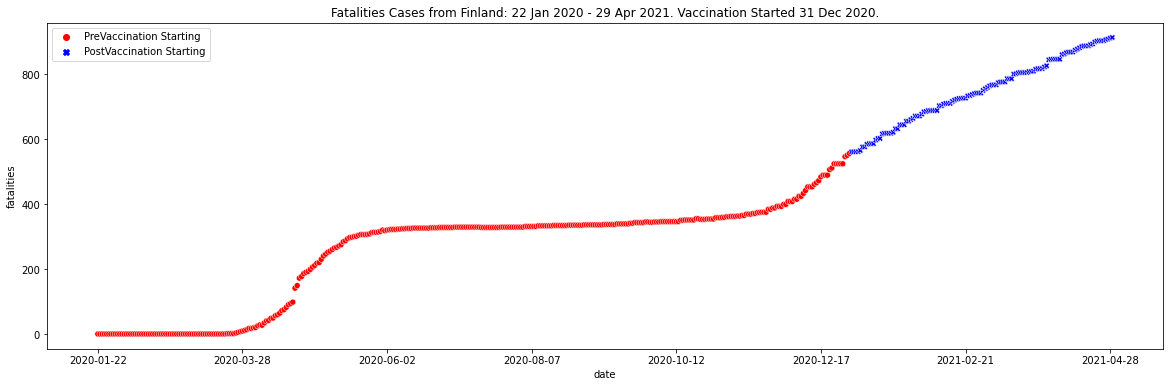

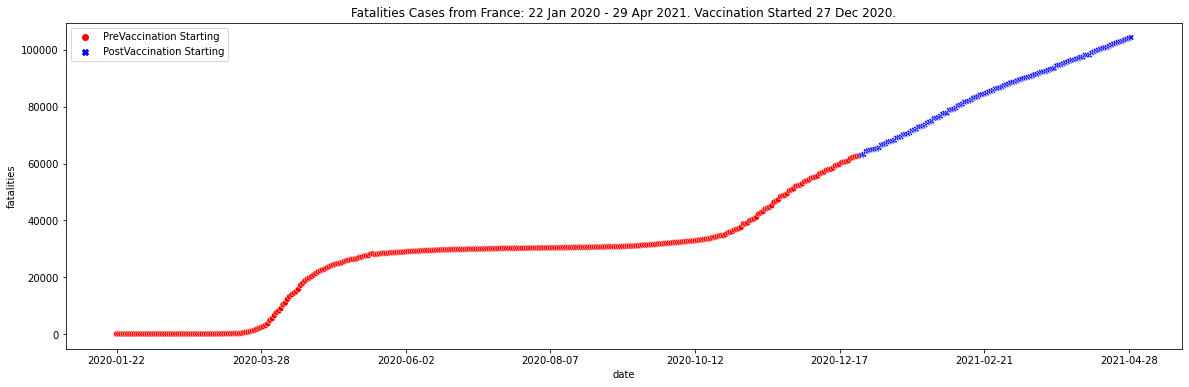

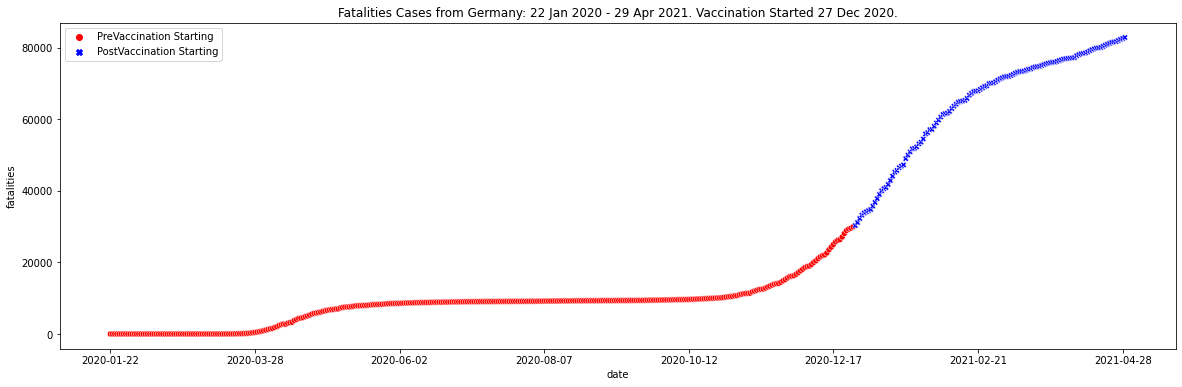

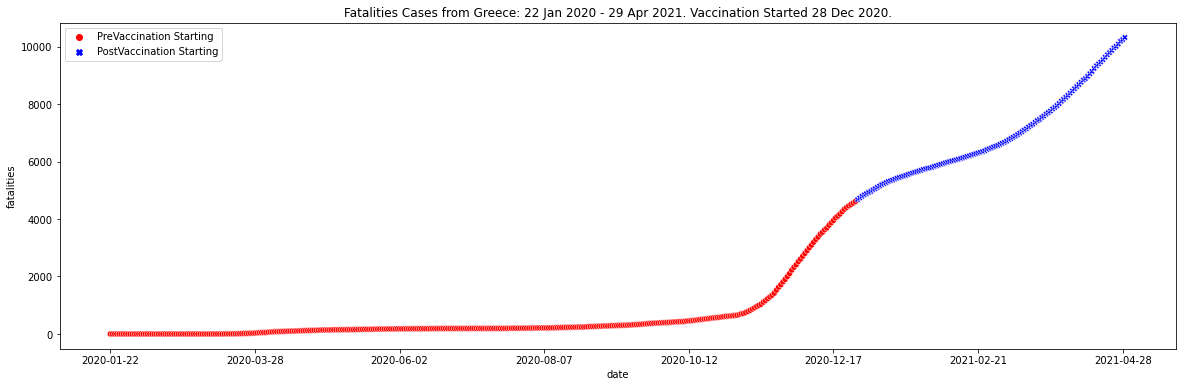

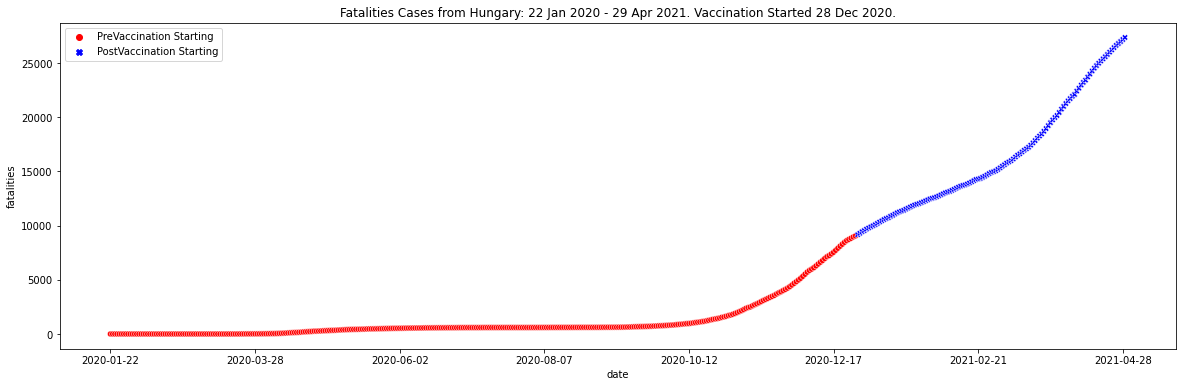

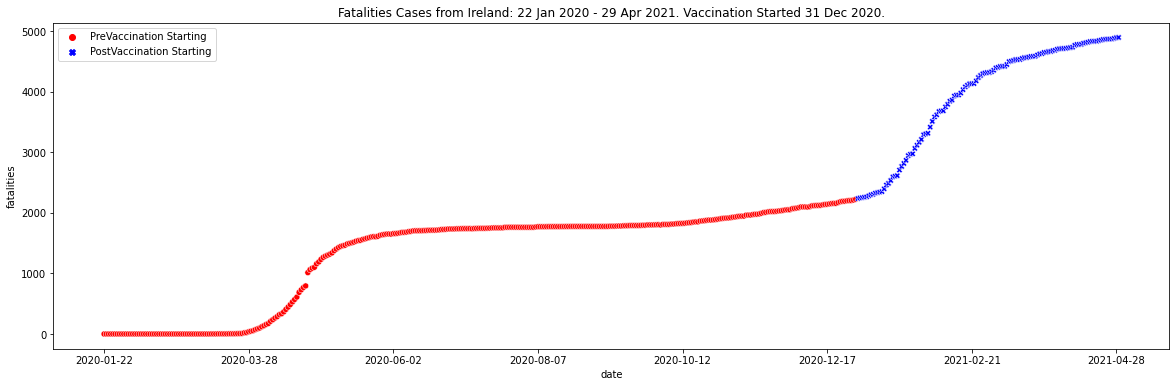

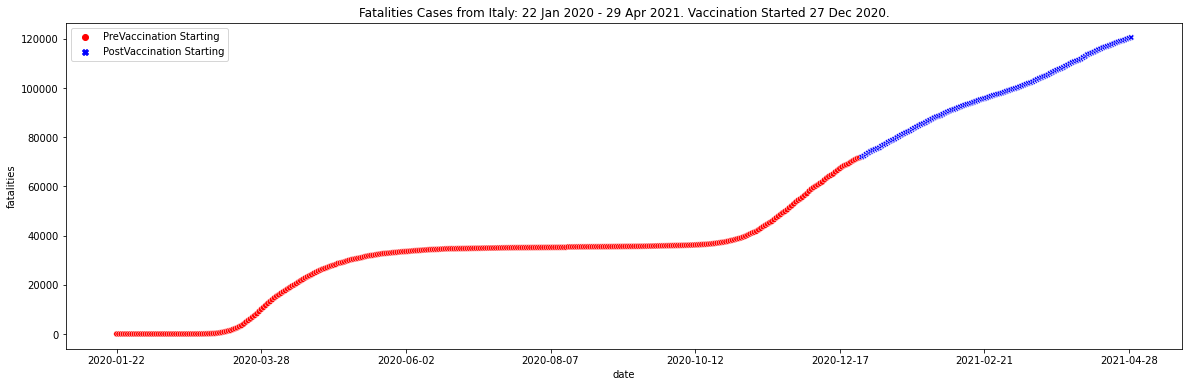

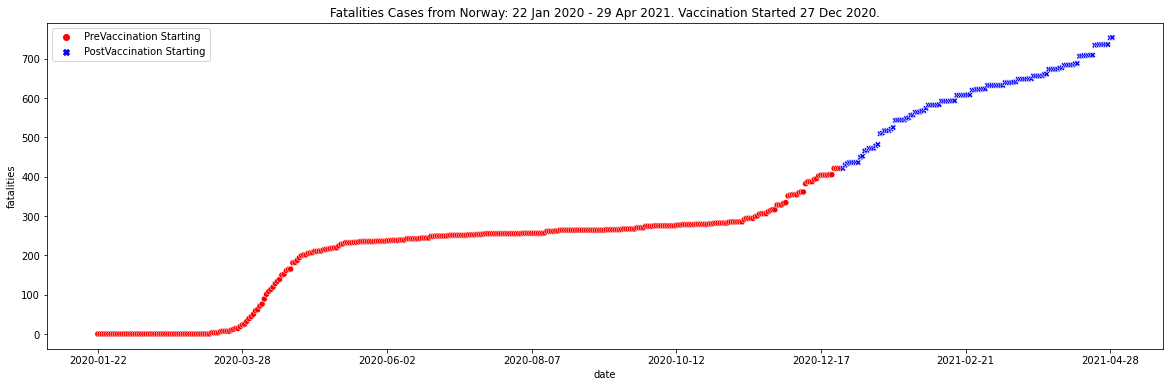

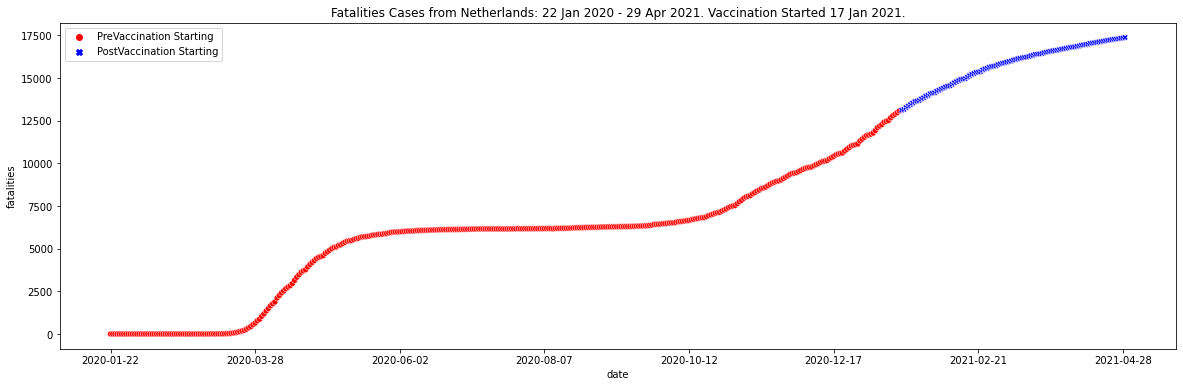

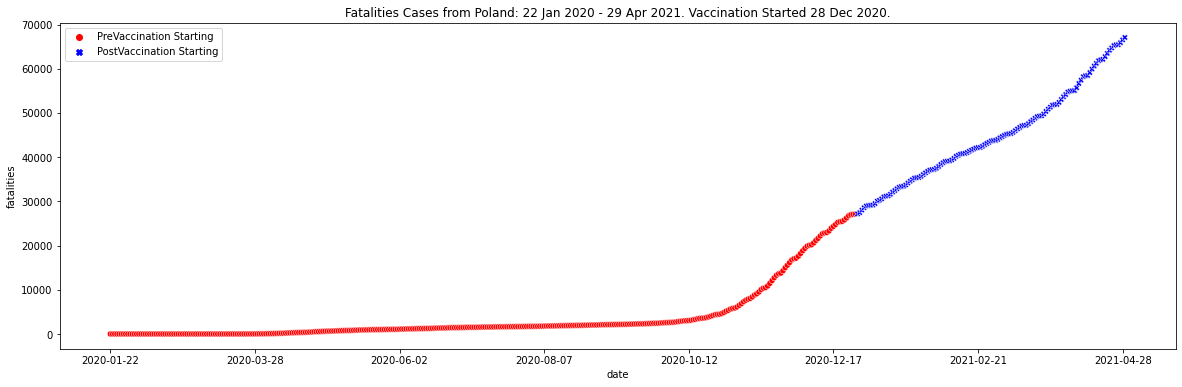

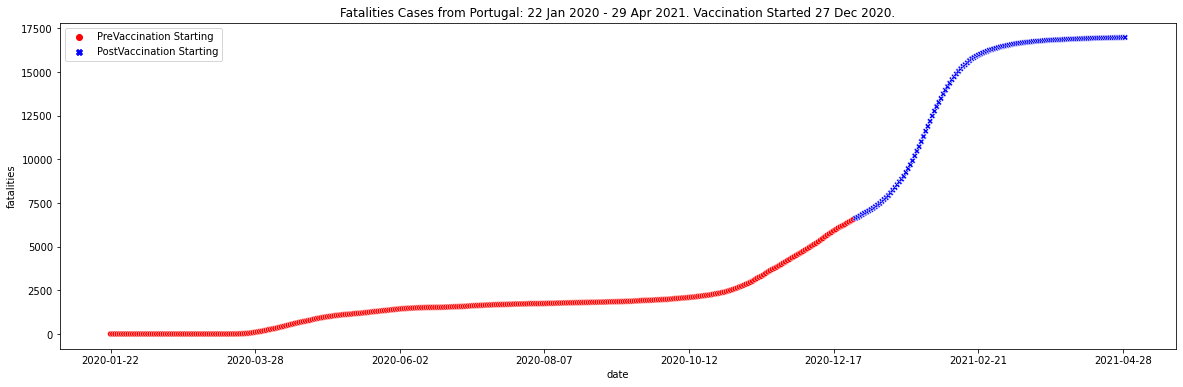

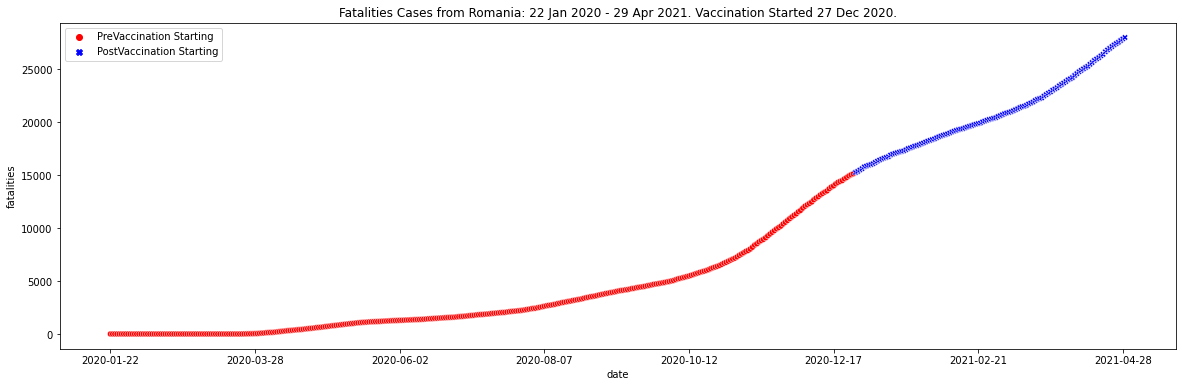

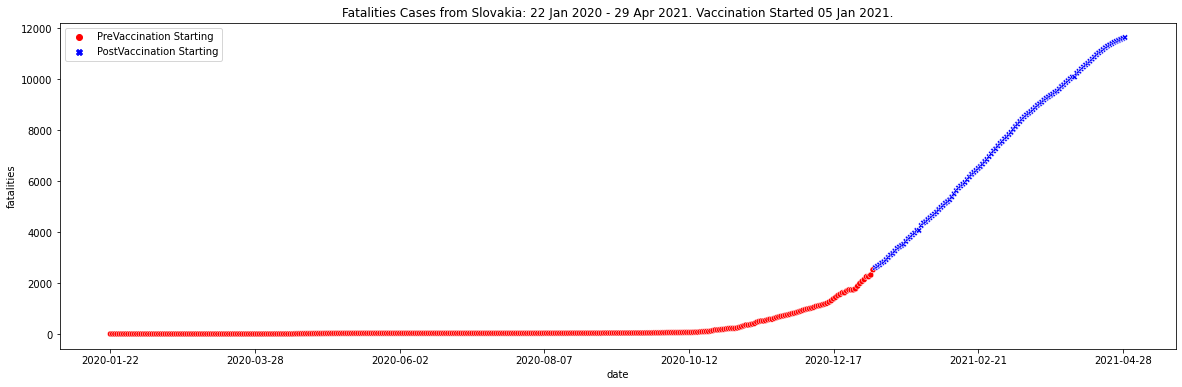

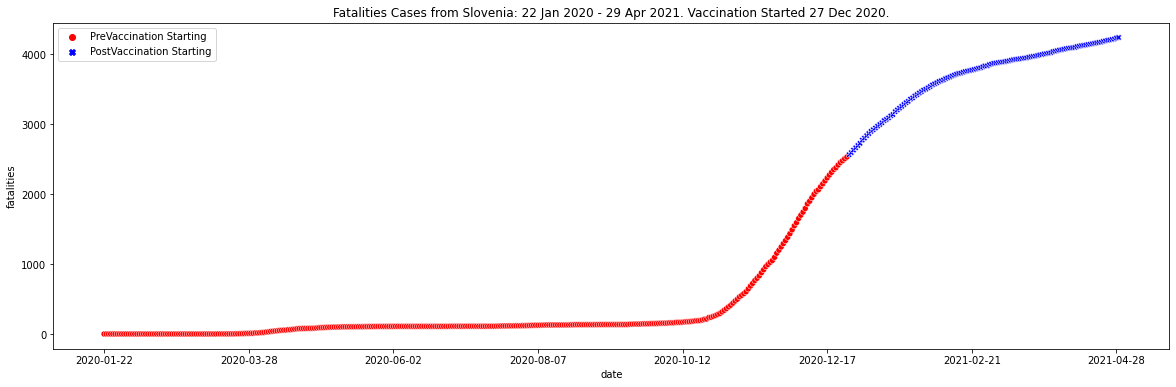

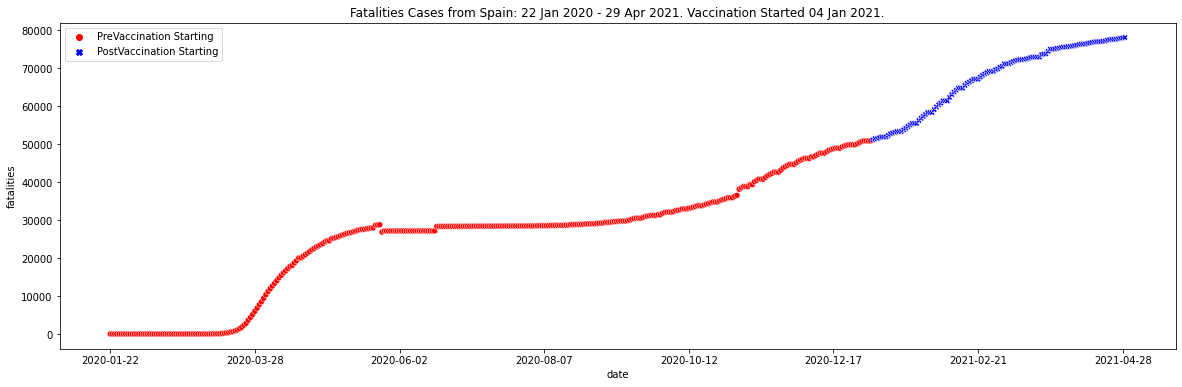

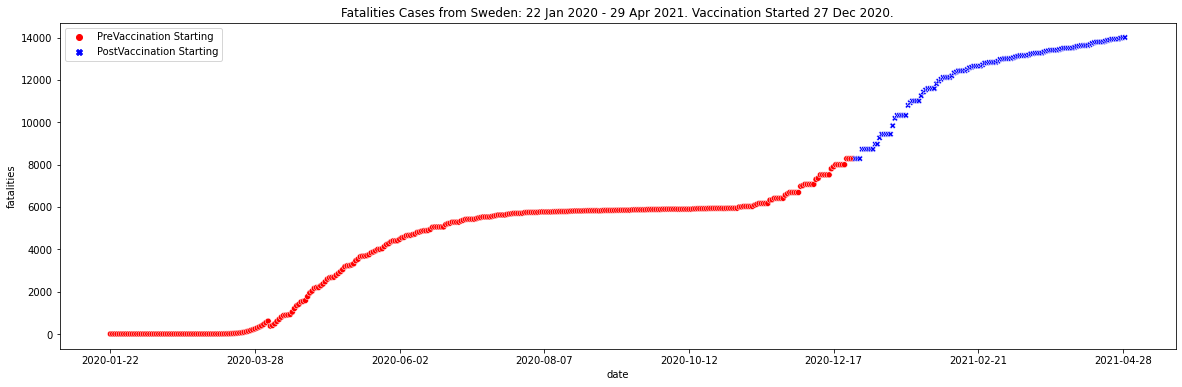

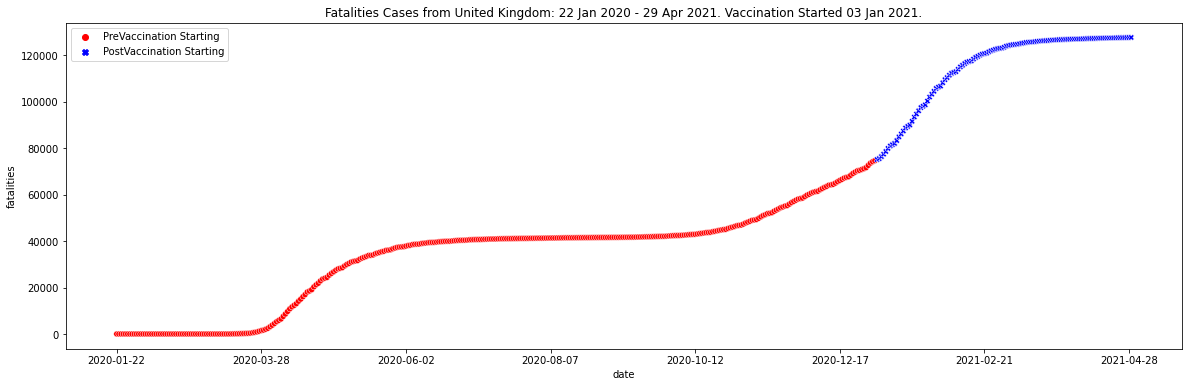

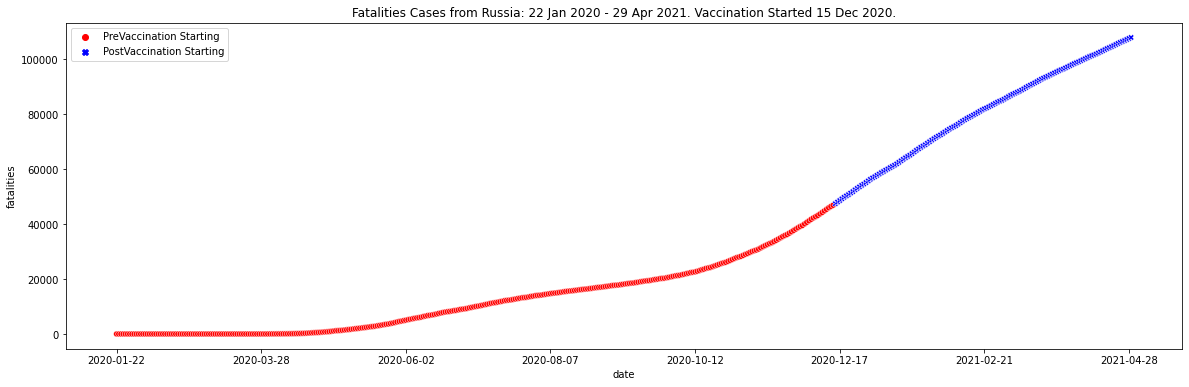

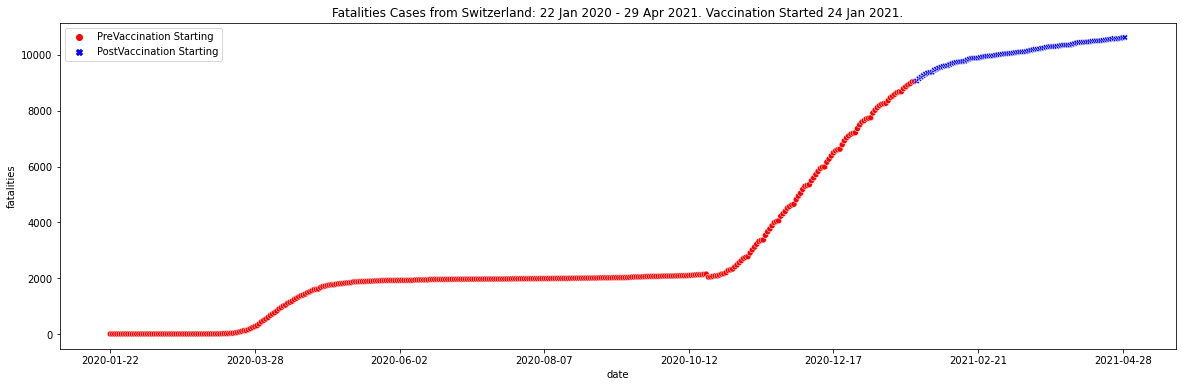

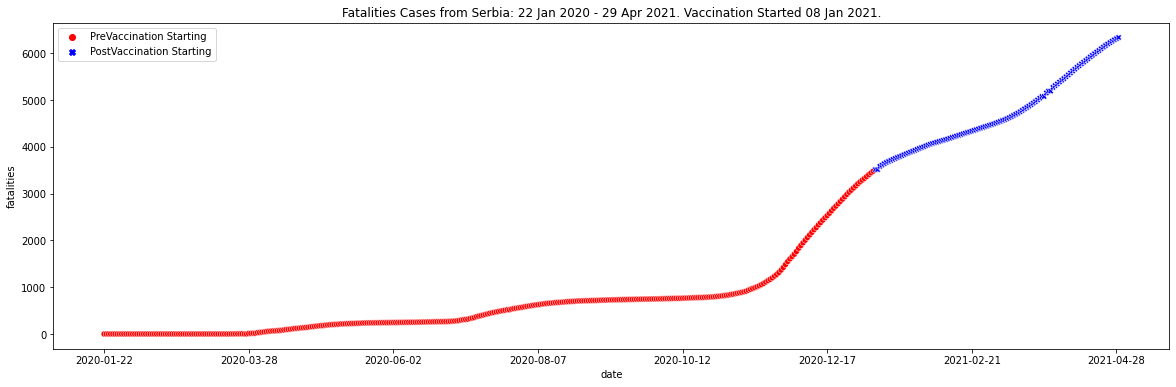

In [33]:
for i in europian:
    plot_country_fatalities(i)

The time vs deaths plot is more telling of how important vaccination has been in the fight against Covid. After the start of vacciantion process, no of deaths and thus mortality rate has reduced in a regular manner.

In [34]:
def get_title( country, date_range, scaling = 'Fatalities' ):
    status = "Vaccination 10% done"
    date = get_vaccination_tendone(country)
    return '{0} Cases from {1}: {2}. {3} {4}.'.format(scaling,
                                                        country,
                                                        date_range,
                                                        status,
                                                        get_date_str(date))

In [35]:
def plot_country_ten_fatal(country = 'Spain'):
    vaccination_started_date = get_vaccination_tendone(country)
    country_data        = train.loc[(train.country == country),:]


    dates       = country_data.date
    cases       = country_data.fatalities
 
    vaccination_started = ["Post 10%" if l else "Pre 10%" for l in pd.to_datetime(country_data.date) >= vaccination_started_date]
 
    plt.figure(figsize=(20,6))
    sns.set_palette("RdBu_r",1)
    
    
    if vaccination_started[0] != vaccination_started[-1]:
        sns.scatterplot(x=dates,y=cases, hue=vaccination_started, style=vaccination_started, palette=['r','b'])
    else: 
        sns.scatterplot(x=dates,y=cases, hue=vaccination_started, style=vaccination_started, palette=['b'])
        
    plt.title(get_title(country, get_date_range(country_data)))
    plt.xticks(get_date_ticks(country_data))
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



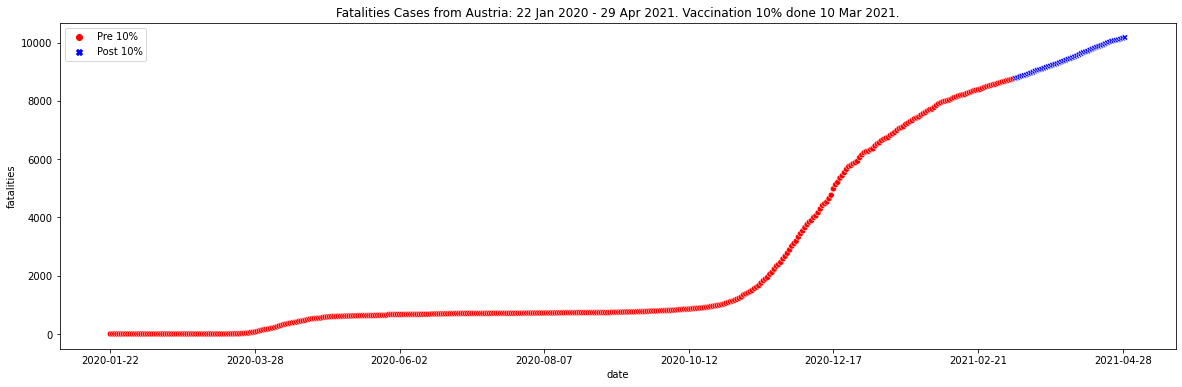

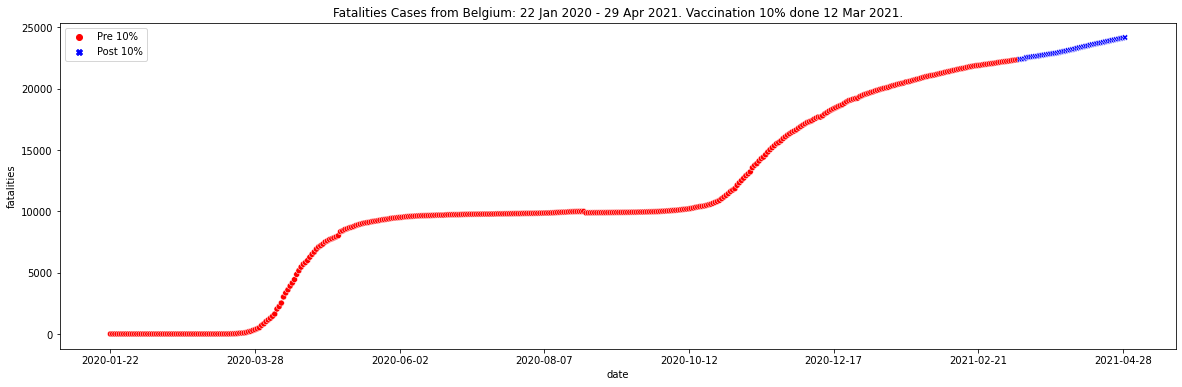

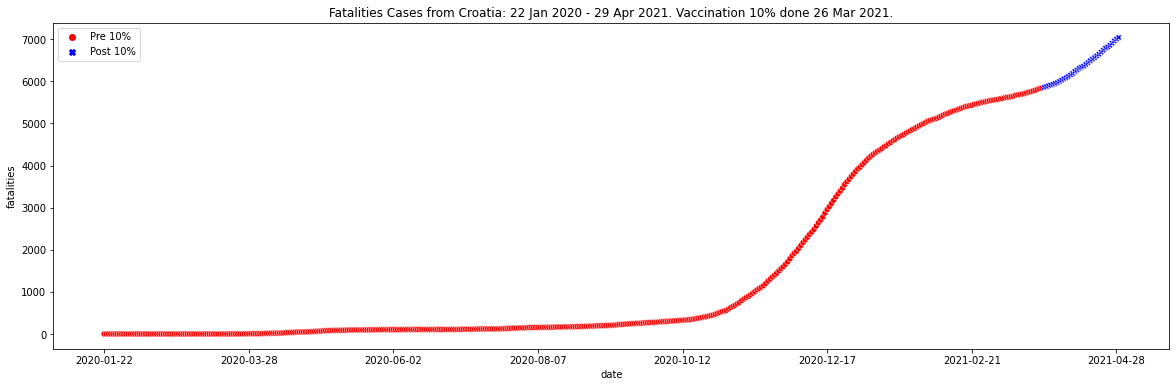

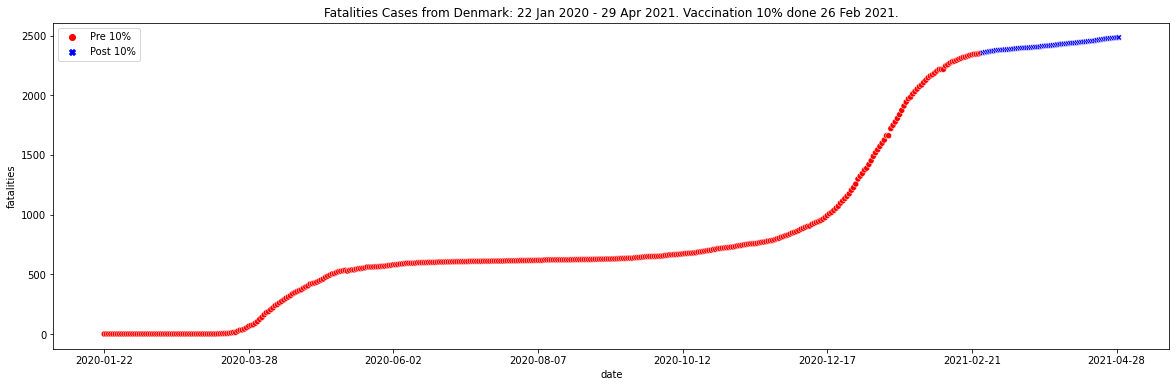

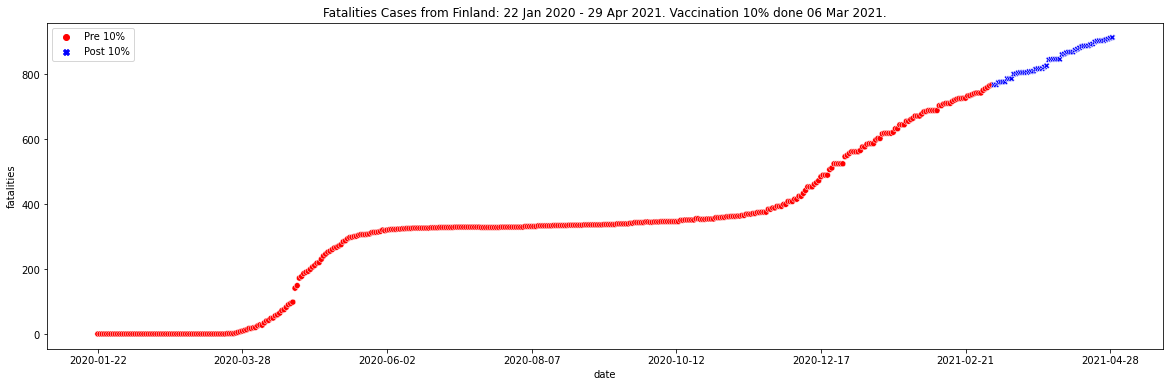

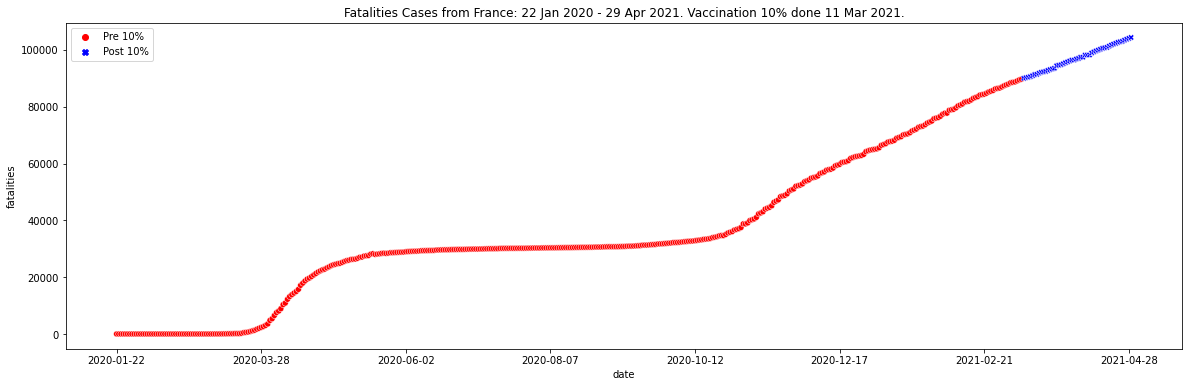

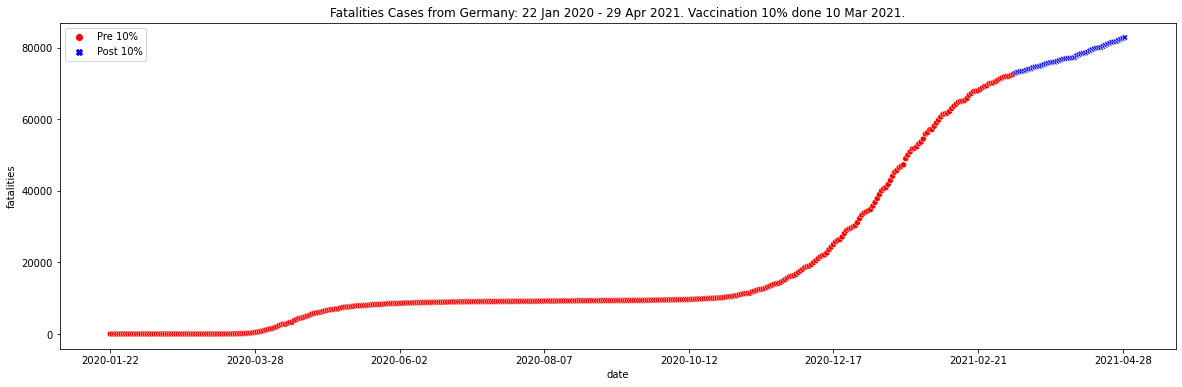

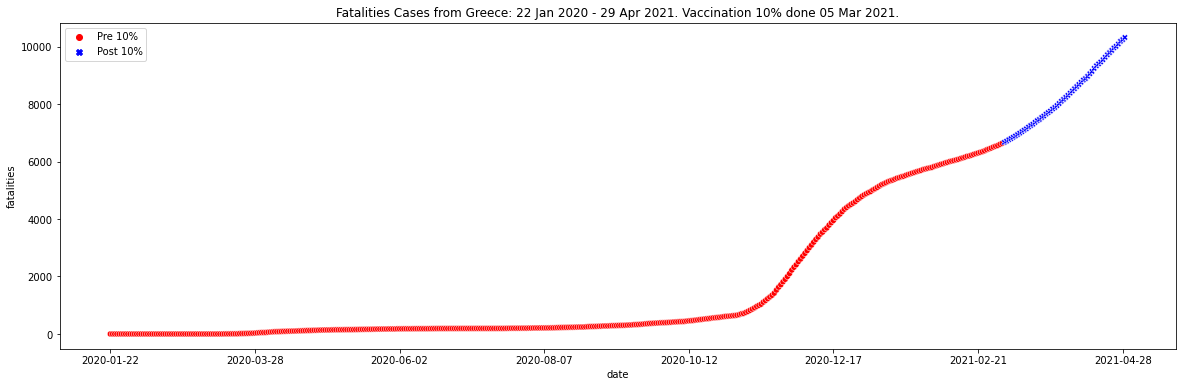

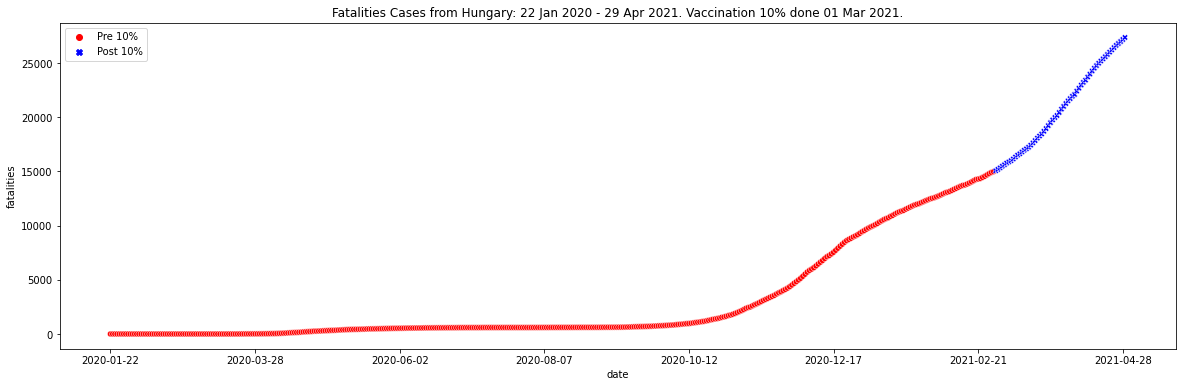

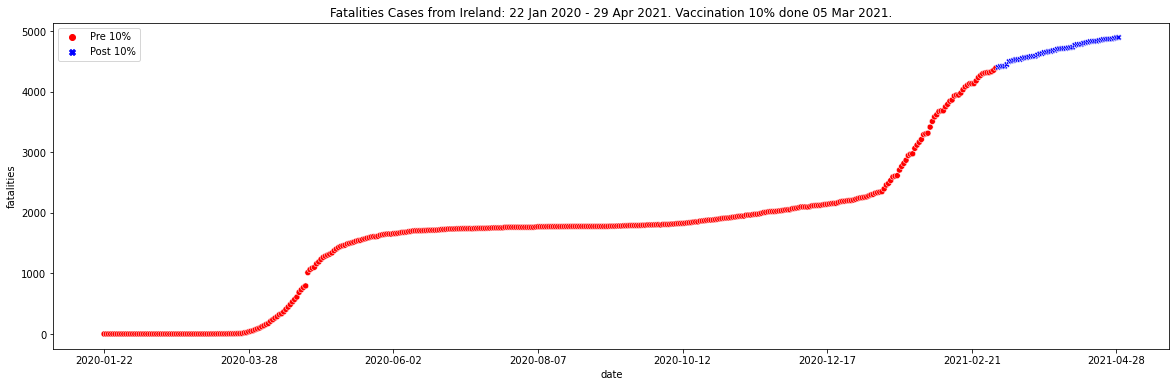

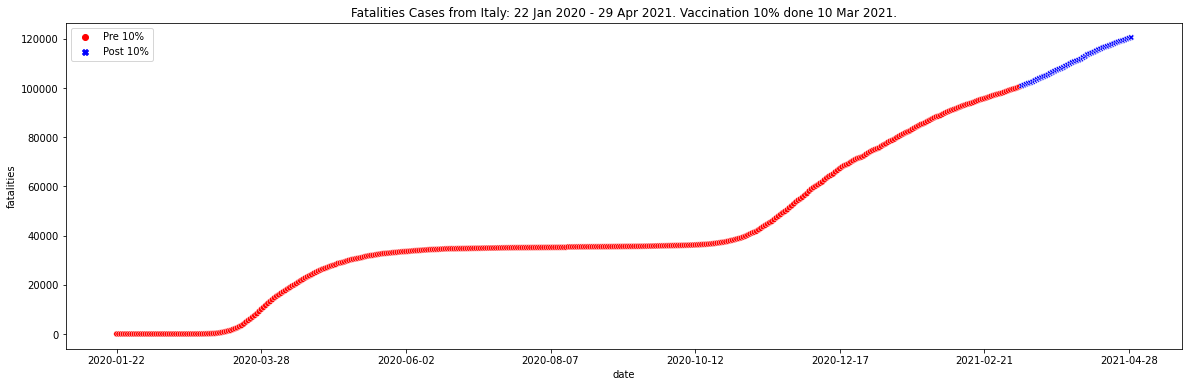

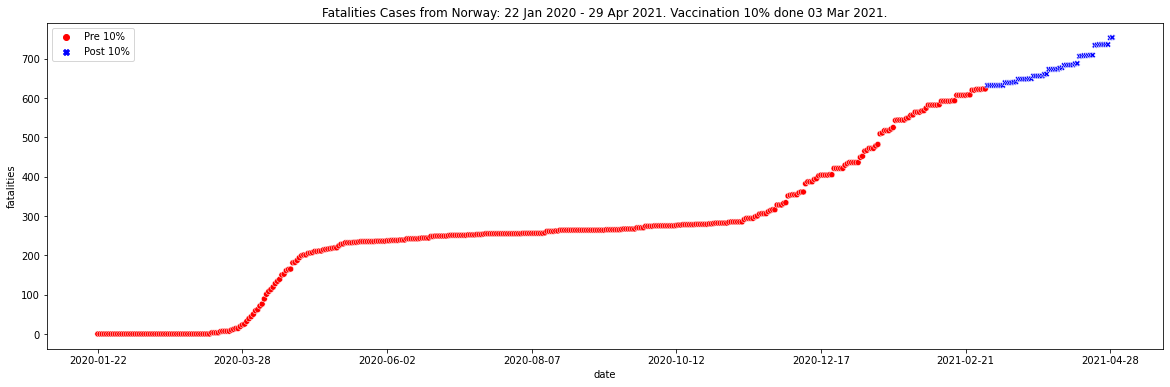

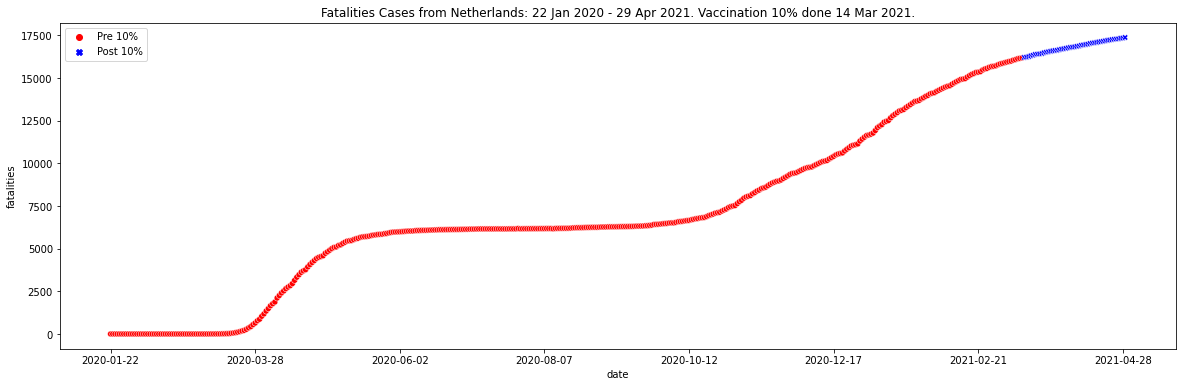

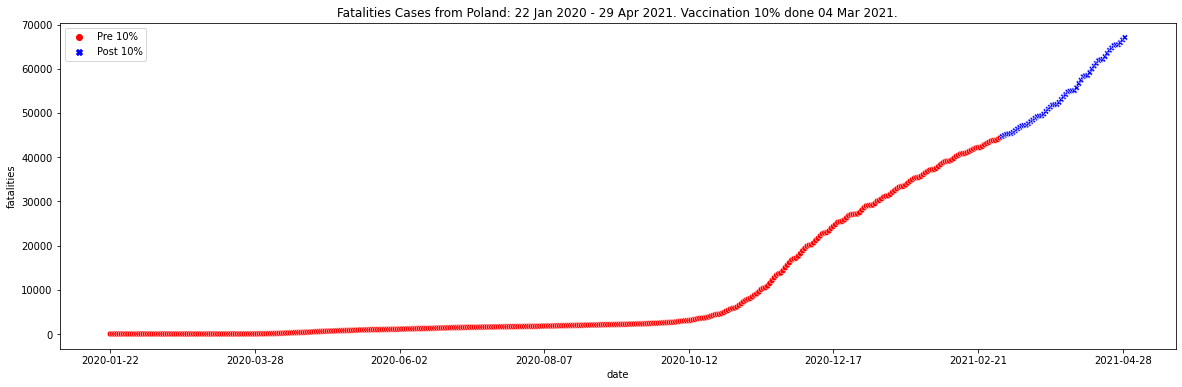

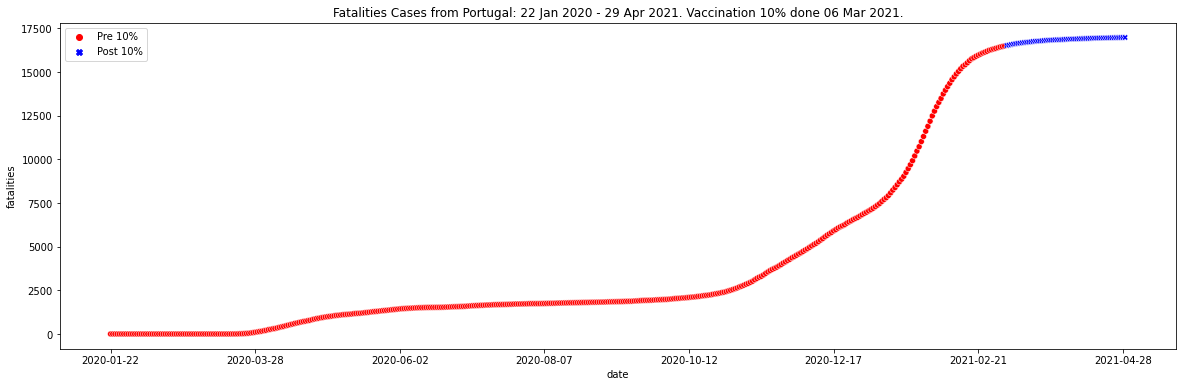

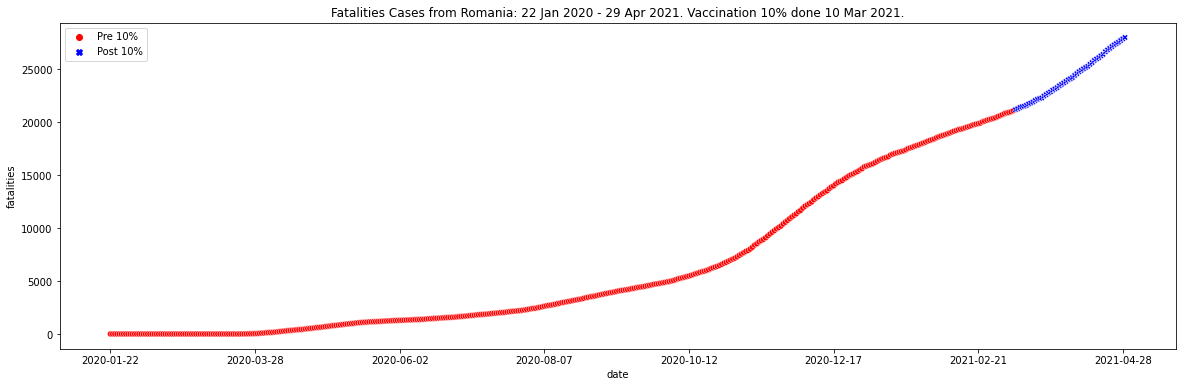

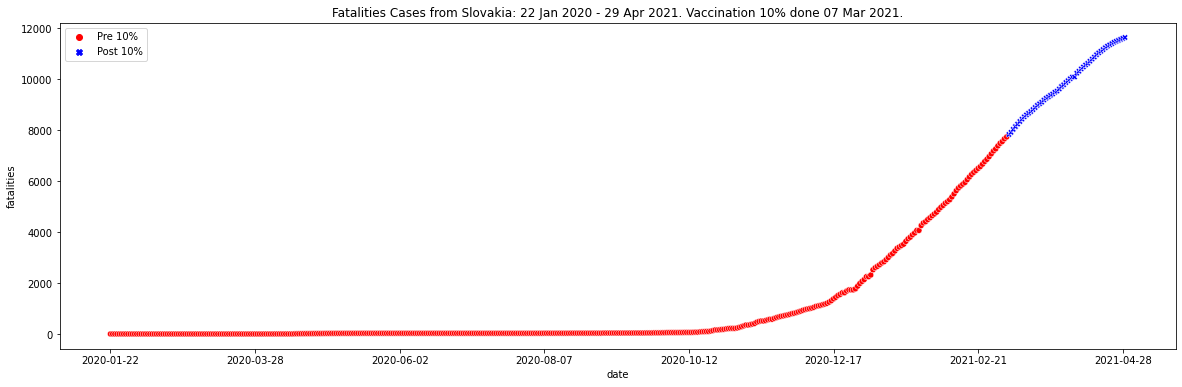

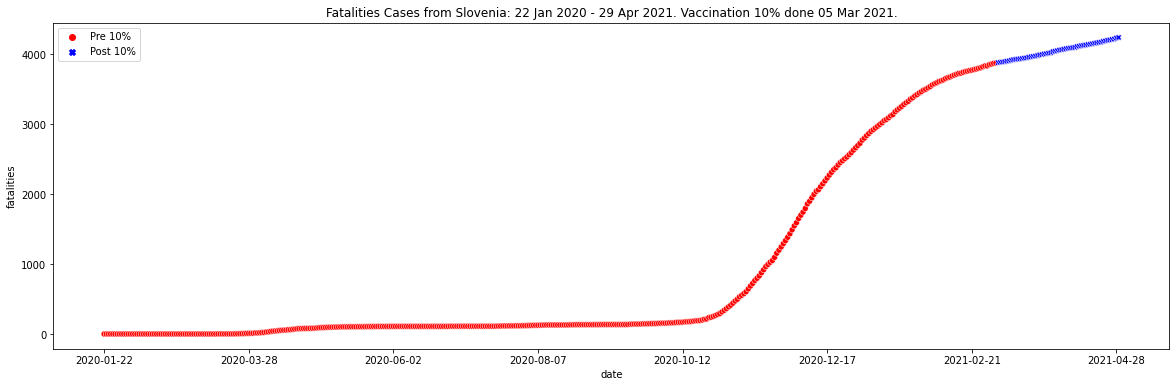

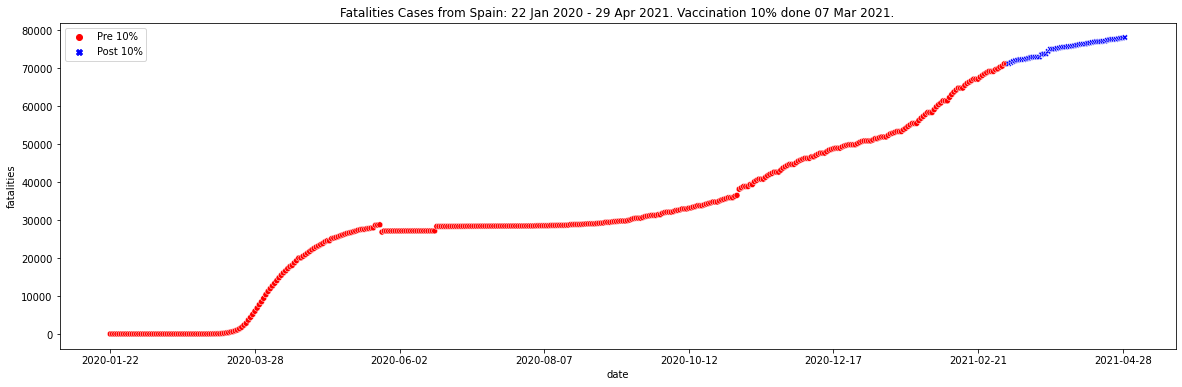

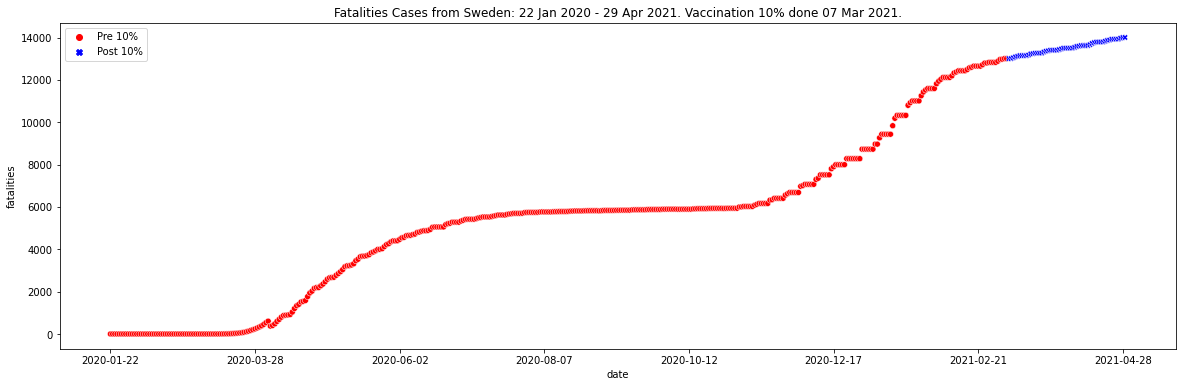

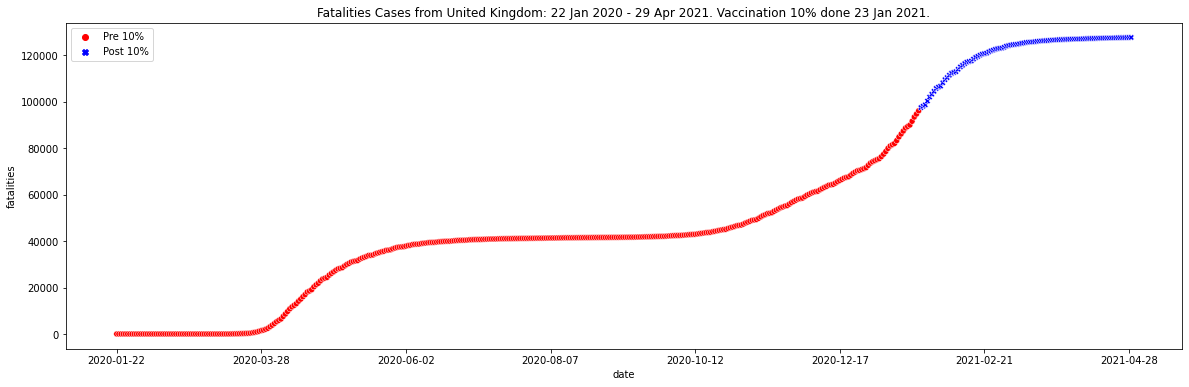

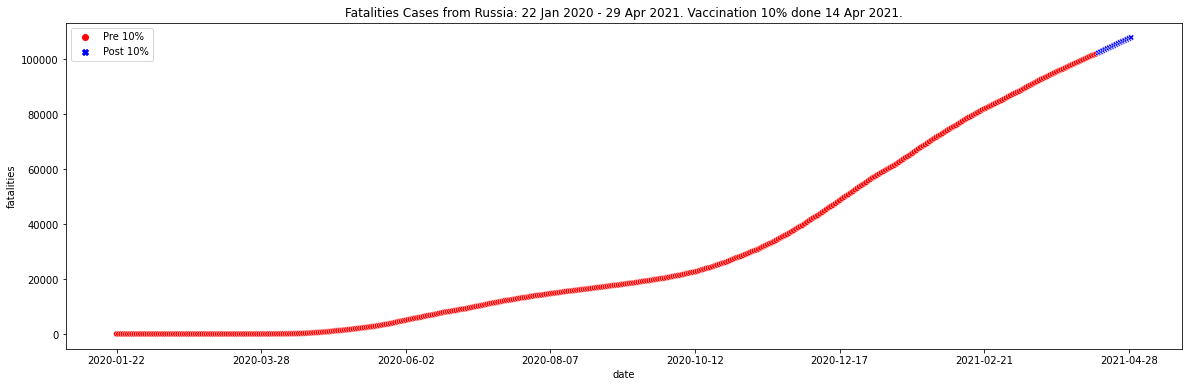

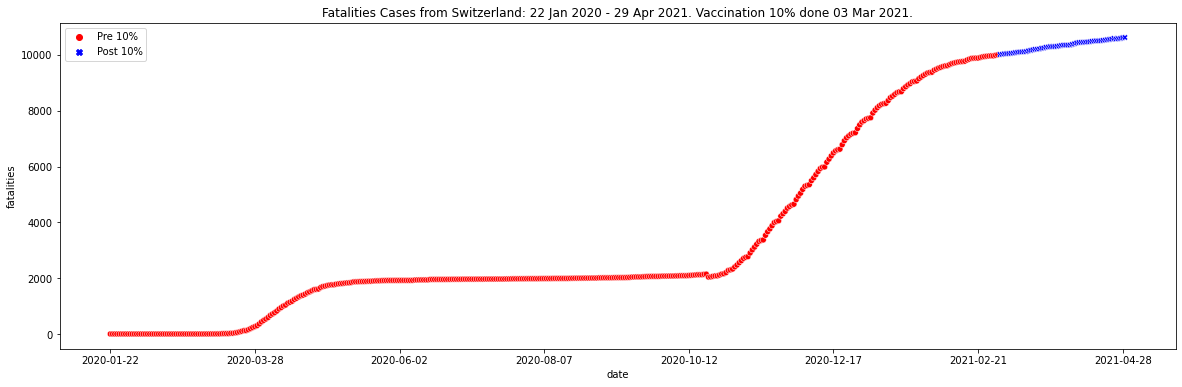

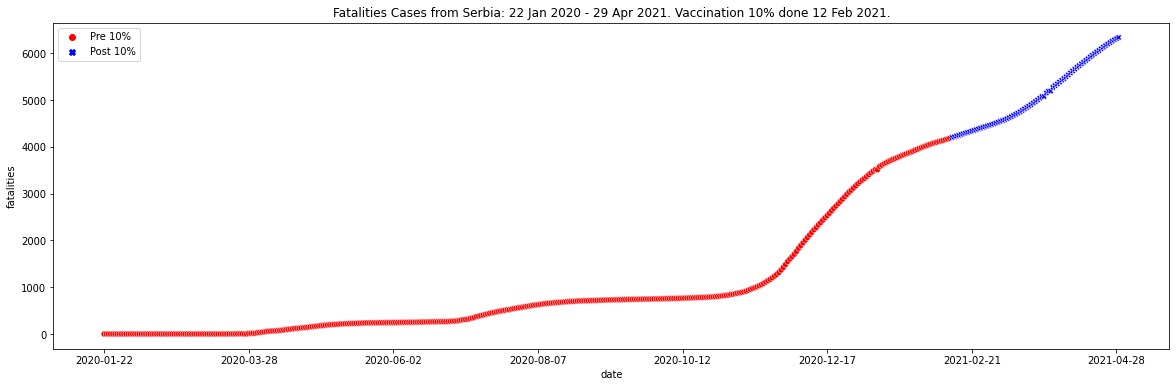

In [36]:
for i in europian:
    plot_country_ten_fatal(i)

The above graphs depicting no of deaths before and after completion of vaccination of 10% of country's population shows that the hypothesis that increase in vaccination decreases no of deaths and mortality rate. Now we can try and use a machine learning model to test our hypothesis.

# **QUANTITATIVE ANALYSIS OF EFFECT OF VACCINATION ON COVID-19**

In [37]:
%%time
import requests

for filename in ['time_series_covid19_confirmed_global.csv',
                 'time_series_covid19_deaths_global.csv',
                 'time_series_covid19_recovered_global.csv',
                 ]:
    print(f'Downloading {filename}')
    url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/{filename}'
    myfile = requests.get(url)
    open(filename, 'wb').write(myfile.content)

CPU times: user 57.4 ms, sys: 12 ms, total: 69.5 ms
Wall time: 496 ms


In [38]:
from datetime import datetime

def _convert_date_str(df):
    try:
        df.columns = list(df.columns[:4]) + [datetime.strptime(d, "%m/%d/%y").date().strftime("%Y-%m-%d") for d in df.columns[4:]]
    except:
        print('_convert_date_str failed with %y, try %Y')
        df.columns = list(df.columns[:4]) + [datetime.strptime(d, "%m/%d/%Y").date().strftime("%Y-%m-%d") for d in df.columns[4:]]


confirmed_global_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
_convert_date_str(confirmed_global_df)

deaths_global_df = pd.read_csv('time_series_covid19_deaths_global.csv')
_convert_date_str(deaths_global_df)

recovered_global_df = pd.read_csv('time_series_covid19_recovered_global.csv')
_convert_date_str(recovered_global_df)

In [39]:


confirmed_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)
deaths_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)
recovered_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)



In [40]:
confirmed_global_melt_df = confirmed_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='ConfirmedCases')
deaths_global_melt_df = deaths_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='Deaths')
recovered_global_melt_df = deaths_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='Recovered')

In [41]:
train = confirmed_global_melt_df.merge(deaths_global_melt_df, on=['Country_Region', 'Province_State', 'Lat', 'Long', 'Date'])
train = train.merge(recovered_global_melt_df, on=['Country_Region', 'Province_State', 'Lat', 'Long', 'Date'])

In [42]:
train.rename({'Country_Region': 'country', 'Province_State': 'province', 'Id': 'id', 'Date': 'date', 'ConfirmedCases': 'confirmed', 'Deaths': 'fatalities', 'Recovered': 'recovered'}, axis=1, inplace=True)
train['country_province'] = train['country'].fillna('') + '/' + train['province'].fillna('')

In [43]:
europe_country_list =list([
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland',
    'Italy', 'Latvia','Luxembourg','Lithuania','Malta','Norway','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
    'Spain', 'Sweden', 'United Kingdom', 'Iceland', 'Russia', 'Switzerland', 'Serbia', 'Ukraine', 'Belarus',
    'Albania', 'Bosnia and Herzegovina', 'Kosovo', 'Moldova', 'Montenegro', 'North Macedonia'])

In [44]:
train = train[train['country'].isin(europe_country_list)]

train = train.groupby(['date', 'country']).sum()

train = train.drop(['Lat', 'Long'], axis = 1)
train.reset_index(inplace=True)

In [45]:
df = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.



In [46]:
df = df[df['country_region'].isin(europe_country_list)]
df.shape

(1381991, 15)

In [47]:
df = df.drop(['sub_region_1', 'sub_region_2', 'country_region_code', 'sub_region_2', 'metro_area',
              'iso_3166_2_code', 'census_fips_code', 'place_id'], axis = 1)

In [48]:
df = df.groupby(['date', 'country_region']).sum()

df.reset_index(inplace=True)

df.rename({'country_region': 'country'}, axis=1, inplace=True)

In [49]:
train = train.merge(df, on=['country', 'date'])

train1 = train.drop(['country'], axis = 1)
datewise = train1.groupby(["date"]).sum()

datewise.reset_index(inplace=True)

datewise['date'] = datewise['date'].astype('datetime64[ns]')
datewise.dtypes

date                                                  datetime64[ns]
confirmed                                                      int64
fatalities                                                     int64
recovered                                                      int64
retail_and_recreation_percent_change_from_baseline           float64
grocery_and_pharmacy_percent_change_from_baseline            float64
parks_percent_change_from_baseline                           float64
transit_stations_percent_change_from_baseline                float64
workplaces_percent_change_from_baseline                      float64
residential_percent_change_from_baseline                     float64
dtype: object

In [50]:
datewise["Days"]=datewise.date - datewise.date.min()

datewise["Days"]=datewise["Days"].dt.days
datewise

date  confirmed  fatalities  recovered  \
0   2020-02-15         56           1          1   
1   2020-02-16         56           1          1   
2   2020-02-17         57           1          1   
3   2020-02-18         57           1          1   
4   2020-02-19         58           1          1   
..         ...        ...         ...        ...   
431 2021-04-21   43152096      982091     982091   
432 2021-04-22   43339856      985704     985704   
433 2021-04-23   43510361      989334     989334   
434 2021-04-24   43642870      992183     992183   
435 2021-04-25   43749949      994084     994084   

     retail_and_recreation_percent_change_from_baseline  \
0                                               5361.0    
1                                               4779.0    
2                                              10328.0    
3                                              12544.0    
4                                               9294.0    
..                                                 ...    
431                                           -41425.0    
432                                           -43535.0    
433                                           -49375.0    
434                                           -58826.0    
435                                           -48996.0    

     grocery_and_pharmacy_percent_change_from_baseline  \
0                                                634.0   
1                                              -1266.0   
2                                               5024.0   
3                                               4393.0   
4                                               2225.0   
..                                                 ...   
431                                            22838.0   
432                                            23920.0   
433                                            27269.0   
434                                            18084.0   
435                                            15004.0   

     parks_percent_change_from_baseline  \
0                               10171.0   
1                               -3431.0   
2                               20690.0   
3                               25474.0   
4                               15443.0   
..                                  ...   
431                             38679.0   
432                             41887.0   
433                             47188.0   
434                             66337.0   
435                             66074.0   

     transit_stations_percent_change_from_baseline  \
0                                           8380.0   
1                                           4841.0   
2                                           1476.0   
3                                             74.0   
4                                          -2305.0   
..                                             ...   
431                                       -50923.0   
432                                       -54977.0   
433                                       -51304.0   
434                                       -40705.0   
435                                       -39354.0   

     workplaces_percent_change_from_baseline  \
0                                     -648.0   
1                                    -2152.0   
2                                   -10400.0   
3                                   -15749.0   
4                                   -16340.0   
..                                       ...   
431                                 -74943.0   
432                                 -73759.0   
433                                 -64567.0   
434                                 -14330.0   
435                                 -12449.0   

     residential_percent_change_from_baseline  Days  
0                                      -135.0     0  
1                                      -273.0     1  
2                                      2062.0     2  
3                   

In [51]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.85)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.85):]

In [52]:
train_ml

date  confirmed  fatalities  recovered  \
0   2020-02-15         56           1          1   
1   2020-02-16         56           1          1   
2   2020-02-17         57           1          1   
3   2020-02-18         57           1          1   
4   2020-02-19         58           1          1   
..         ...        ...         ...        ...   
365 2021-02-14   32116454      763309     763309   
366 2021-02-15   32216350      766294     766294   
367 2021-02-16   32337749      770970     770970   
368 2021-02-17   32484052      775627     775627   
369 2021-02-18   32636492      779481     779481   

     retail_and_recreation_percent_change_from_baseline  \
0                                               5361.0    
1                                               4779.0    
2                                              10328.0    
3                                              12544.0    
4                                               9294.0    
..                                                 ...    
365                                           -93841.0    
366                                           -75579.0    
367                                           -79938.0    
368                                           -84005.0    
369                                           -82737.0    

     grocery_and_pharmacy_percent_change_from_baseline  \
0                                                634.0   
1                                              -1266.0   
2                                               5024.0   
3                                               4393.0   
4                                               2225.0   
..                                                 ...   
365                                           -21885.0   
366                                           -16191.0   
367                                            -7625.0   
368                                           -11322.0   
369                                            -6252.0   

     parks_percent_change_from_baseline  \
0                               10171.0   
1                               -3431.0   
2                               20690.0   
3                               25474.0   
4                               15443.0   
..                                  ...   
365                             -5321.0   
366                             -3821.0   
367                             -2858.0   
368                             -8977.0   
369                             -6172.0   

     transit_stations_percent_change_from_baseline  \
0                                           8380.0   
1                                           4841.0   
2                                           1476.0   
3                                             74.0   
4                                          -2305.0   
..                                             ...   
365                                       -75048.0   
366                                       -88340.0   
367                                       -86135.0   
368                                       -84331.0   
369                                       -84174.0   

     workplaces_percent_change_from_baseline  \
0                                     -648.0   
1                                    -2152.0   
2                                   -10400.0   
3                                   -15749.0   
4                                   -16340.0   
..                                       ...   
365                                 -41181.0   
366                                -110298.0   
367                                -115883.0   
368                                -103675.0   
369                                -105029.0   

     residential_percent_change_from_baseline  Days  
0                                      -135.0     0  
1                                      -273.0     1  
2                                      2062.0     2  
3                   

In [53]:
valid_ml

date  confirmed  fatalities  recovered  \
370 2021-02-19   32789571      783578     783578   
371 2021-02-20   32916610      786175     786175   
372 2021-02-21   33025828      787973     787973   
373 2021-02-22   33127646      790805     790805   
374 2021-02-23   33260225      794918     794918   
..         ...        ...         ...        ...   
431 2021-04-21   43152096      982091     982091   
432 2021-04-22   43339856      985704     985704   
433 2021-04-23   43510361      989334     989334   
434 2021-04-24   43642870      992183     992183   
435 2021-04-25   43749949      994084     994084   

     retail_and_recreation_percent_change_from_baseline  \
370                                           -90811.0    
371                                           -98357.0    
372                                           -88982.0    
373                                           -69143.0    
374                                           -72783.0    
..                                                 ...    
431                                           -41425.0    
432                                           -43535.0    
433                                           -49375.0    
434                                           -58826.0    
435                                           -48996.0    

     grocery_and_pharmacy_percent_change_from_baseline  \
370                                            -2126.0   
371                                           -11591.0   
372                                           -17264.0   
373                                            -7200.0   
374                                            -3871.0   
..                                                 ...   
431                                            22838.0   
432                                            23920.0   
433                                            27269.0   
434                                            18084.0   
435                                            15004.0   

     parks_percent_change_from_baseline  \
370                            -10748.0   
371                              8817.0   
372                             34503.0   
373                              8857.0   
374                             16317.0   
..                                  ...   
431                             38679.0   
432                             41887.0   
433                             47188.0   
434                             66337.0   
435                             66074.0   

     transit_stations_percent_change_from_baseline  \
370                                       -84477.0   
371                                       -69457.0   
372                                       -61459.0   
373                                       -78432.0   
374                                       -78574.0   
..                                             ...   
431                                       -50923.0   
432                                       -54977.0   
433                                       -51304.0   
434                                       -40705.0   
435                                       -39354.0   

     workplaces_percent_change_from_baseline  \
370                                 -94931.0   
371                                 -39443.0   
372                                 -36380.0   
373                                 -99744.0   
374                                -105211.0   
..                                       ...   
431                                 -74943.0   
432                                 -73759.0   
433                                 -64567.0   
434                                 -14330.0   
435                                 -12449.0   

     residential_percent_change_from_baseline  Days  
370                                   31242.0   370  
371                                   13813.0   371  
372                                    8777.0   372  
373                 

In [54]:
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing

In [55]:
es=ExponentialSmoothing(np.asarray(train_ml['fatalities']),seasonal_periods=14,trend='add', seasonal='mul').fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [56]:
y_pred=valid_ml.copy()
y_pred["Holt's Winter Model"]=es.forecast(len(valid_ml))

In [57]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=train_ml.index, y=train_ml["fatalities"],
                    mode='lines+markers',name="Train Data for Fatalities Cases"))
fig.add_trace(go.Scatter(x=valid_ml.index, y=valid_ml["fatalities"],
                    mode='lines+markers',name="Further Recorded data for fatalities",))
fig.add_trace(go.Scatter(x=valid_ml.index, y=y_pred["Holt\'s Winter Model"],
                    mode='lines+markers',name="Prediction of Fatalities Cases",))
fig.update_layout(title="Fatalities Cases Holt's Winter Model Prediction",
                 xaxis_title="Date",yaxis_title="Fatalities",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

The graph above compares predicted no of deaths according to Holt's Winter Model which gavee an accuracy of 0.75% during forecasting and actutal no of deaths. We can observe that actual no of deaths are lower than the predicted counterpart and keeps on decreasing with the passage of time. Hence we can clearly say that vaccination results in fewer deaths due to COVID-19